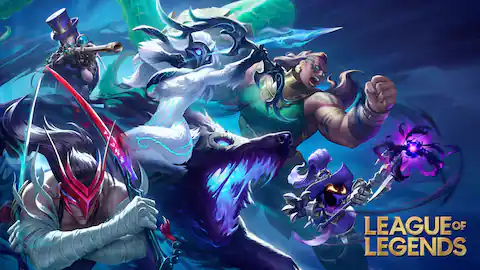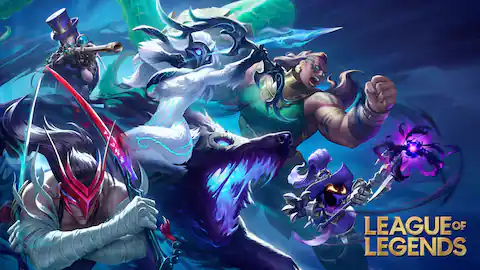

# 문제정의 및 목표 설정
* 우리는 "리그오브레전드" 라는 게임을 매우 좋아한다. 이 게임에는 다양한 티어가 존재하고 티어는 곧 자신의 게임 실력을 나타낸다.<br>
  "챌린저", "그랜드마스터", "마스터" 이 상위 3티어에 있는 유저들의 게임 경기 데이터를 통해 승리에 영향을 미치는 요인을 파악하고,<br>
  이를 바탕으로 우리의 게임 플레이를 개선하여 승률을 높이는 것이 최종 목표이다.

# 가설 설정
1. 블루팀과 레드팀 어느팀이 승률이 더 높은가?
3. 게임을 승리하려면 상대보다 타워를 더 많이 밀어야한다.
4. 게임을 승리하려면 상대보다 킬수가 더 많아야한다.
5. 블루팀과 레드팀 어느 팀이 어떤 오브젝트(드래곤, 바론)를 챙기기에 유리한가 - 지형이 오브젝트에 미치는 영향
7. 게임을 승리하려면 상대보다 골드량이 더 많아야한다.
8. 가장 첫번째의 킬, 오브젝트, 억제기가 게임에 미치는 영향력은 얼마나 될까?

In [4]:
# 필요한 라이브러리 로드
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# 시각화를 위한 폰트 설정
import os
if os.name == "posix":
    sns.set(font="AppleGothic")
elif os.name == "nt":
    sns.set(font="Malgun Gothic")

In [6]:
# 레티나 설정을 해주면 글씨가 좀 더 선명하게 보입니다.
# 폰트의 주변이 흐릿하게 보이는 것을 방지합니다.
%config InlineBackend.figure_format = 'retina'

# 데이터 수집 및 로드
- 출처 : https://www.kaggle.com/datasets/gyejr95/league-of-legends-challenger-ranked-games2020

In [7]:
# "챌린저", "그랜드마스터", "마스터" 경기 데이터가 3개의 파일로 나눠져있으므로 csv로 끝나는 모든 파일 가져오기
file_csv = glob("match-Data/*.csv")
file_csv

['match-Data\\Challenger_Ranked_Games.csv',
 'match-Data\\GrandMaster_Ranked_Games.csv',
 'match-Data\\Master_Ranked_Games.csv']

In [8]:
# 가져온 파일들을 합치기
file_list = []
for file_csv_name in file_csv:
    print(file_csv_name)
    temp = pd.read_csv(file_csv_name, low_memory=False)
    file_list.append(temp)

match-Data\Challenger_Ranked_Games.csv
match-Data\GrandMaster_Ranked_Games.csv
match-Data\Master_Ranked_Games.csv


In [9]:
# shape를 통해 행과 열을 보니 제대로 합쳐졌음을 볼 수 있음.
lol_df = pd.concat(file_list)
lol_df.shape

(199925, 50)

# 데이터 전처리

In [10]:
lol_df.columns

Index(['gameId', 'gameDuraton', 'blueWins', 'blueFirstBlood', 'blueFirstTower',
       'blueFirstBaron', 'blueFirstDragon', 'blueFirstInhibitor',
       'blueDragonKills', 'blueBaronKills', 'blueTowerKills',
       'blueInhibitorKills', 'blueWardPlaced', 'blueWardkills', 'blueKills',
       'blueDeath', 'blueAssist', 'blueChampionDamageDealt', 'blueTotalGold',
       'blueTotalMinionKills', 'blueTotalLevel', 'blueAvgLevel',
       'blueJungleMinionKills', 'blueKillingSpree', 'blueTotalHeal',
       'blueObjectDamageDealt', 'redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor',
       'redDragonKills', 'redBaronKills', 'redTowerKills', 'redInhibitorKills',
       'redWardPlaced', 'redWardkills', 'redKills', 'redDeath', 'redAssist',
       'redChampionDamageDealt', 'redTotalGold', 'redTotalMinionKills',
       'redTotalLevel', 'redAvgLevel', 'redJungleMinionKills',
       'redKillingSpree', 'redTotalHeal', 'redObjectDamageDealt'],
    

## 컬럼설명 (레드팀 동일)
* gameDuraton - 경기 시간
* blueWins - 승/패 블루팀승리(1/0)
* blueFirstBlood - 가장 먼저 상대팀의 챔피언을 킬했는지 여부 (1/0)
* blueFirstTower - 가장 먼저 상대팀의 타워를 부셨는지 여부 (1/0)
* blueFirstBaron - 첫번째 바론을 잡았는지 여부 (1/0)
* blueFirstDragon - 첫번째 드래곤을 잡았는지 여부 (1/0)
* blueFirstInhibitor - 첫번째 억제기를 부셨는지 여부 (1/0)
* blueTowerKills - 블루팀이 부신 타워의 개수
* blueBaronKills - 블루팀이 잡은 바론의 수
* blueDragonKills - 블루팀이 잡은 드래곤의 수
* blueInhibitorKills - 블루팀이 부신 억제기 개수
* blueWardPlaced - 블루팀이 사용한 와드의 개수
* blueWardkills - 블루팀이 부신 와드의 개수
* blueKills - 블루팀이 잡은 적 챔피언의 수
* blueDeath - 레드팀에게 잡힌 블루팀 챔피언의 수
* blueAssist - 블루팀의 어시스트 수
* blueChampionDamageDealt - 총 딜량
* blueTotalGold - 블루팀이 게임에서 획득한 총 골드
* blueTotalMinionKills - 블루팀이 잡은 미니언 수
* blueTotalLevel - 블루팀 챔피언들의 레벨 합
* blueAvgLevel - 블루팀 챔피언들의 평균 레벨
* blueJungleMinionKills - 블루팀 정글이 잡은 미니언 개수(정글몬스터 포함)
* blueKillingSpree - 블루팀 챔피언들이 연속 킬 한 횟수(전장에서 죽지 않고 2회 이상 킬한 횟수)
* blueTotalHeal - 블루팀 총 힐량
* blueObjectDamageDealt - 블루팀이 바론, 드래곤을 잡을때 넣은 딜량

In [11]:
# 결측치 확인(존재x)

lol_df.isnull().sum()

gameId                     0
gameDuraton                0
blueWins                   0
blueFirstBlood             0
blueFirstTower             0
blueFirstBaron             0
blueFirstDragon            0
blueFirstInhibitor         0
blueDragonKills            0
blueBaronKills             0
blueTowerKills             0
blueInhibitorKills         0
blueWardPlaced             0
blueWardkills              0
blueKills                  0
blueDeath                  0
blueAssist                 0
blueChampionDamageDealt    0
blueTotalGold              0
blueTotalMinionKills       0
blueTotalLevel             0
blueAvgLevel               0
blueJungleMinionKills      0
blueKillingSpree           0
blueTotalHeal              0
blueObjectDamageDealt      0
redWins                    0
redFirstBlood              0
redFirstTower              0
redFirstBaron              0
redFirstDragon             0
redFirstInhibitor          0
redDragonKills             0
redBaronKills              0
redTowerKills 

In [12]:
# 한 경기에 블루팀과 레드팀이 같이 있으므로 나누기
blue_df = lol_df.loc[:, "blueWins":"blueObjectDamageDealt"].copy()
red_df = lol_df.loc[:, "redWins":].copy()

print(blue_df.shape)
print(blue_df.shape)

# 게임시간을 분이랑 초로 나눠서 들어가게 추가해주기
# 분
blue_df["gameMin"] = lol_df["gameDuraton"] // 60
red_df["gameMin"] = lol_df["gameDuraton"] // 60
# 초
blue_df["gameSec"] = lol_df["gameDuraton"] % 60
red_df["gameSec"] = lol_df["gameDuraton"] % 60

(199925, 24)
(199925, 24)


In [13]:
# 열이 1개 추가된 것을 볼 수 있음

print(blue_df.shape)
print(blue_df.shape)

(199925, 26)
(199925, 26)


array([[<Axes: title={'center': 'blueWins'}>,
        <Axes: title={'center': 'blueFirstBlood'}>,
        <Axes: title={'center': 'blueFirstTower'}>],
       [<Axes: title={'center': 'blueFirstBaron'}>,
        <Axes: title={'center': 'blueFirstDragon'}>,
        <Axes: title={'center': 'blueFirstInhibitor'}>],
       [<Axes: title={'center': 'blueDragonKills'}>,
        <Axes: title={'center': 'blueBaronKills'}>,
        <Axes: title={'center': 'blueTowerKills'}>],
       [<Axes: title={'center': 'blueInhibitorKills'}>,
        <Axes: title={'center': 'blueWardPlaced'}>,
        <Axes: title={'center': 'blueWardkills'}>]], dtype=object)

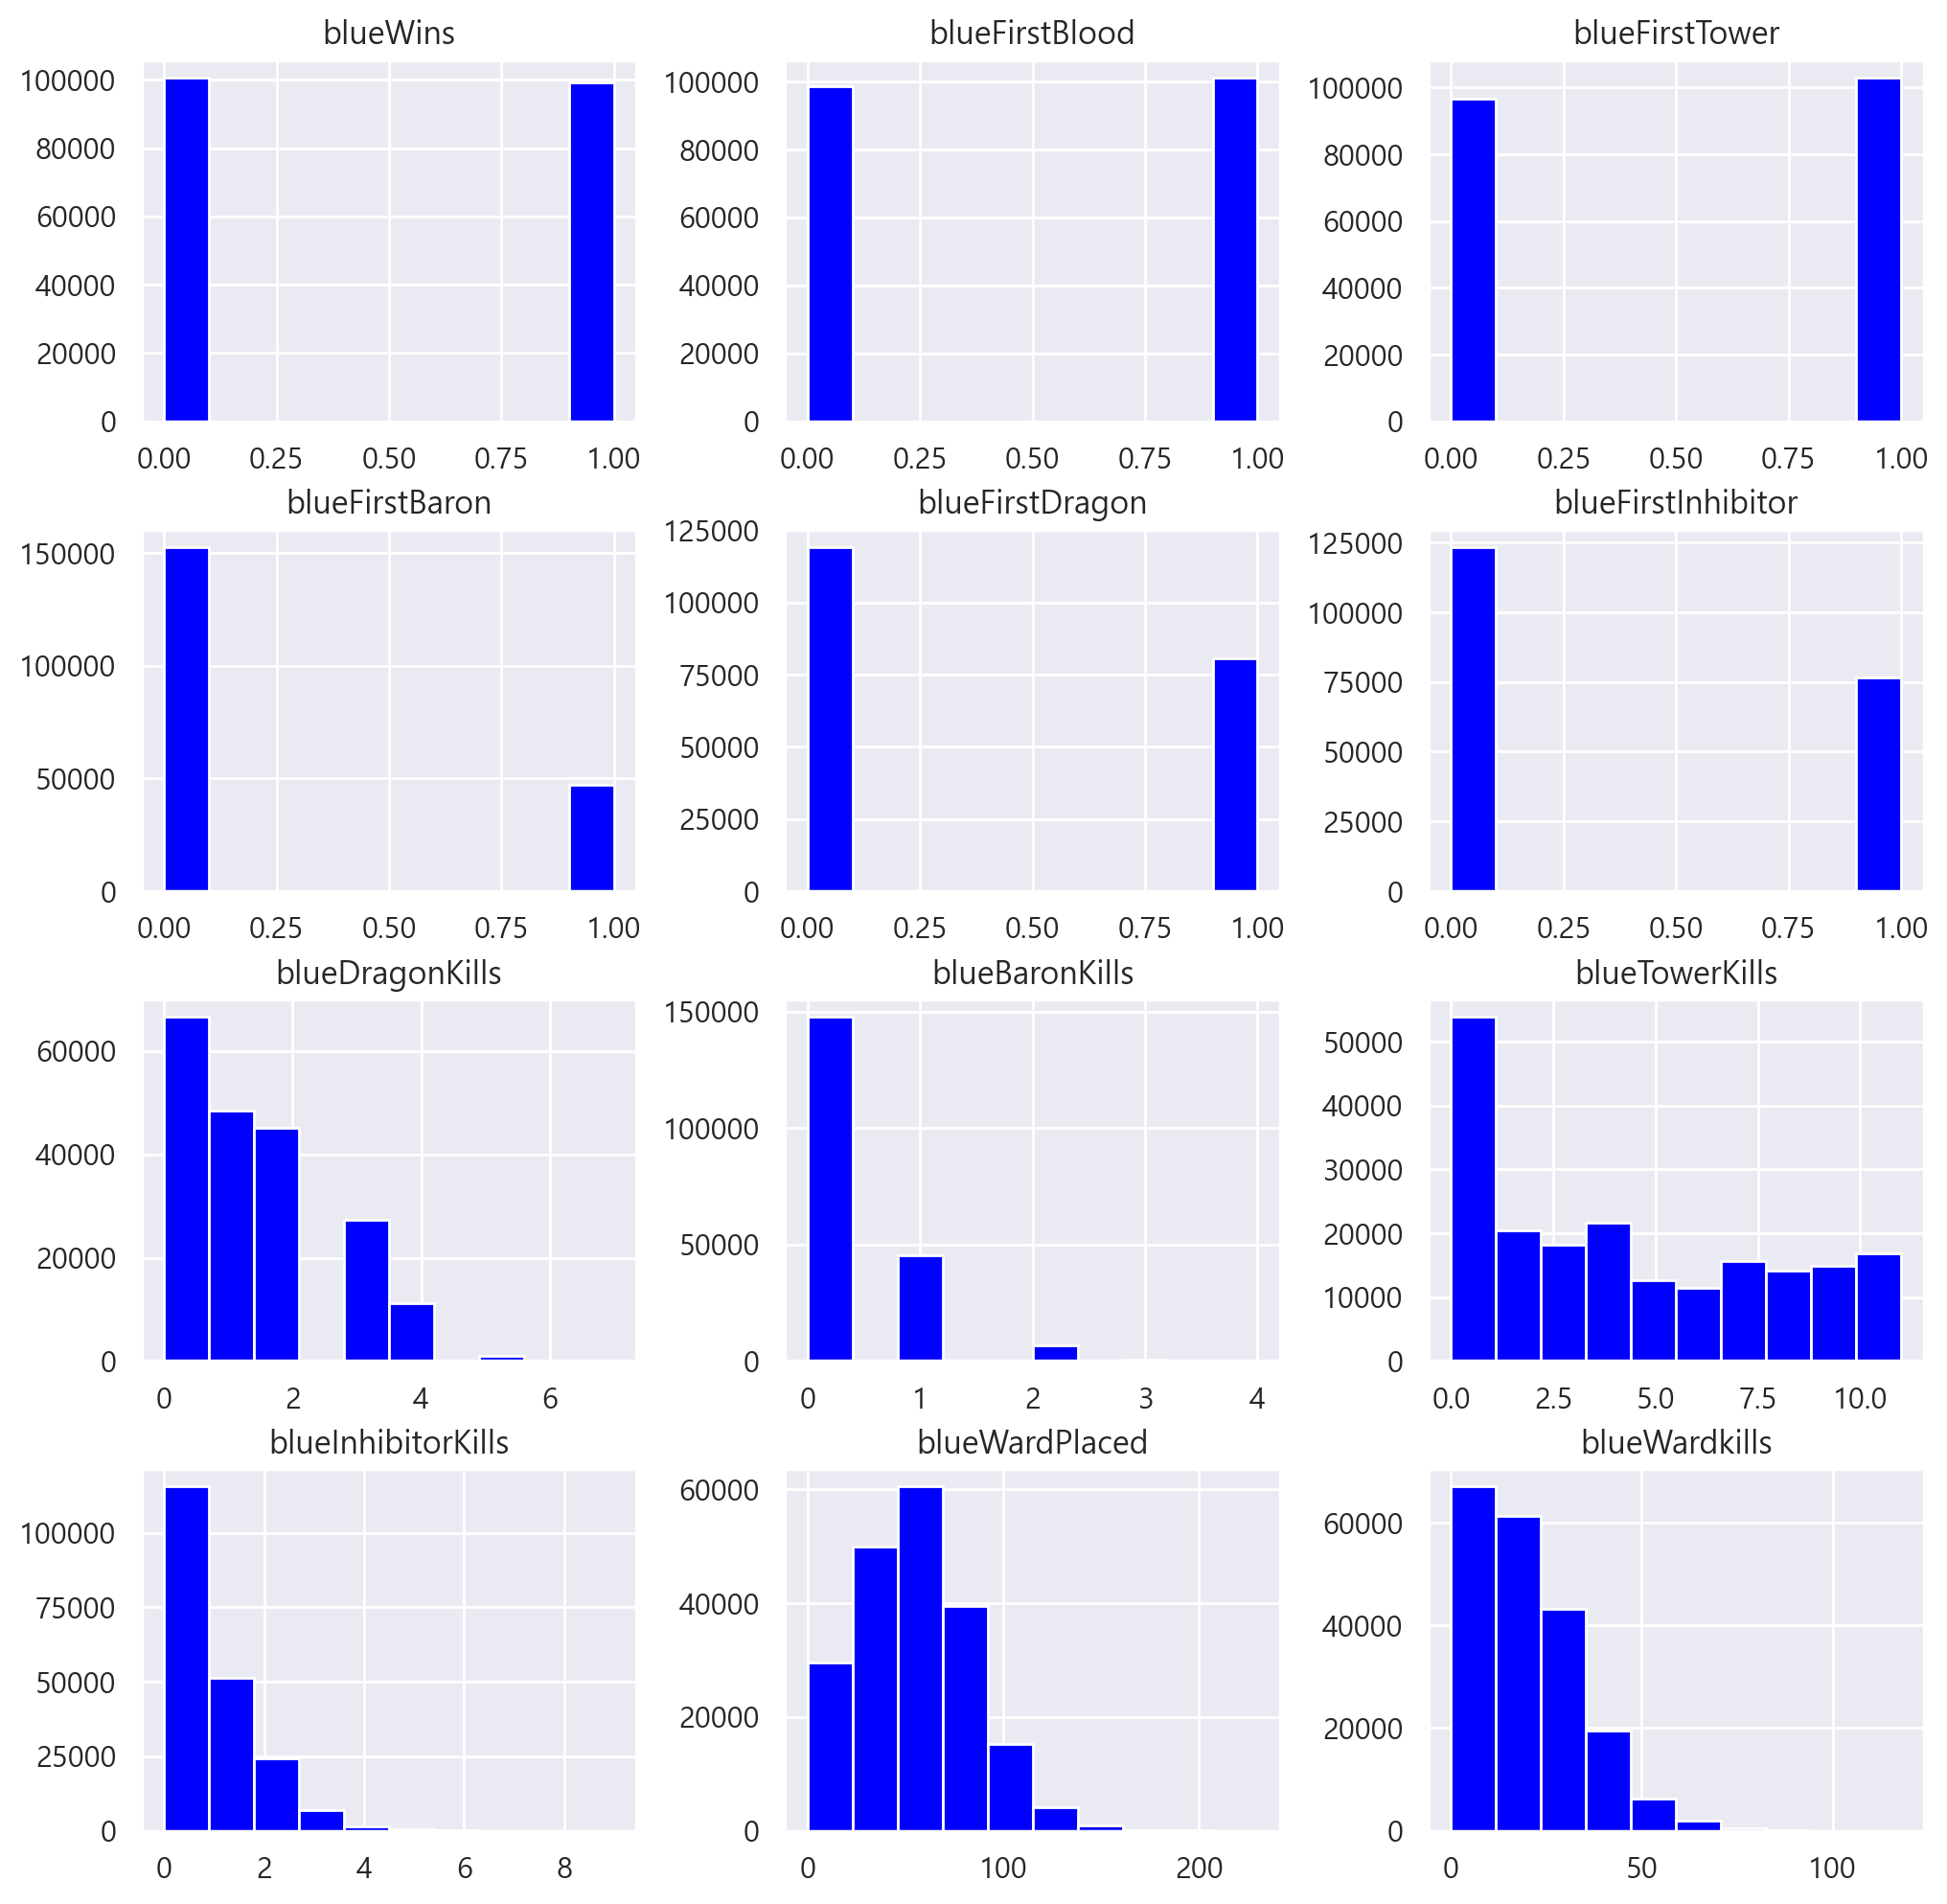

In [14]:
# 이상치 확인(블루팀)
# 히스토그램(Histogram)으로 이상치 확인
# 컬럼이 너무 많아 그래프가 제대로 표현되지 않으므로 나눠서 그림
blue_df.iloc[:, :12].hist(figsize=(12, 12), color='blue')

array([[<Axes: title={'center': 'blueDeath'}>,
        <Axes: title={'center': 'blueAssist'}>,
        <Axes: title={'center': 'blueChampionDamageDealt'}>,
        <Axes: title={'center': 'blueTotalGold'}>],
       [<Axes: title={'center': 'blueTotalMinionKills'}>,
        <Axes: title={'center': 'blueTotalLevel'}>,
        <Axes: title={'center': 'blueAvgLevel'}>,
        <Axes: title={'center': 'blueJungleMinionKills'}>],
       [<Axes: title={'center': 'blueKillingSpree'}>,
        <Axes: title={'center': 'blueTotalHeal'}>,
        <Axes: title={'center': 'blueObjectDamageDealt'}>,
        <Axes: title={'center': 'gameMin'}>],
       [<Axes: title={'center': 'gameSec'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

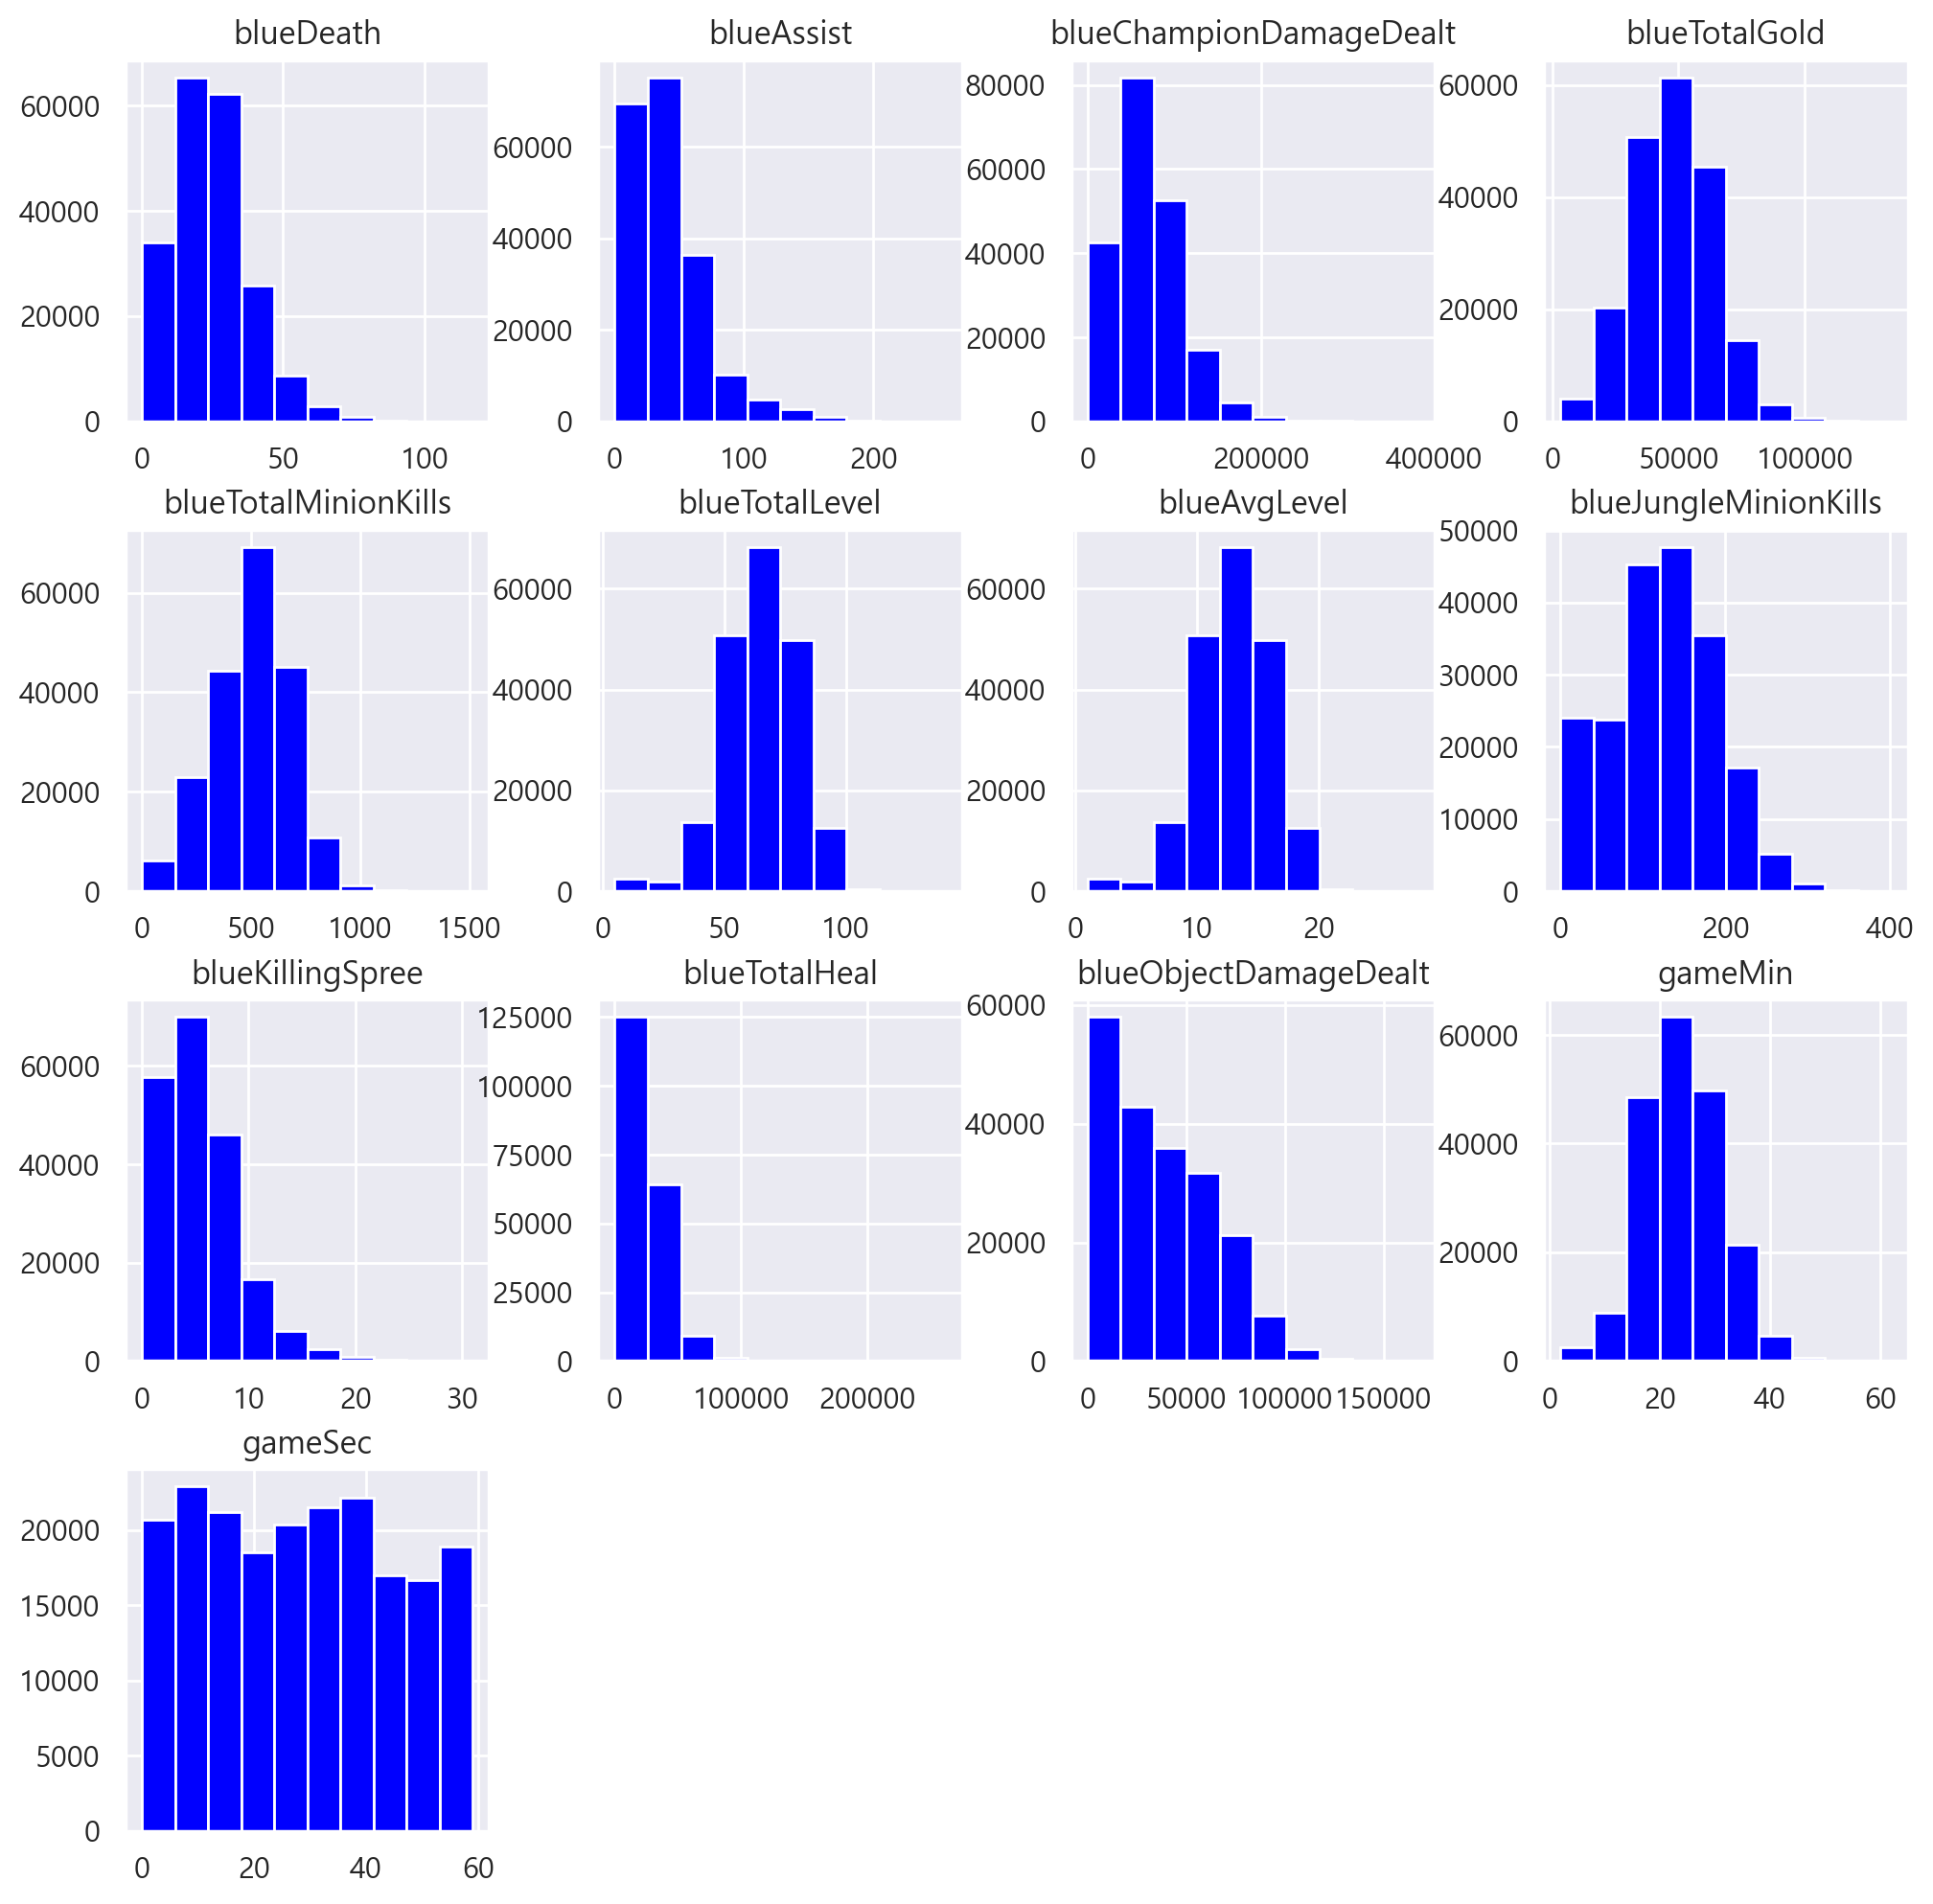

In [15]:
# 12번째 행 이후로 다시 그리기

blue_df.iloc[:, 13:].hist(figsize=(12, 12), color='blue')

array([[<Axes: title={'center': 'redWins'}>,
        <Axes: title={'center': 'redFirstBlood'}>,
        <Axes: title={'center': 'redFirstTower'}>],
       [<Axes: title={'center': 'redFirstBaron'}>,
        <Axes: title={'center': 'redFirstDragon'}>,
        <Axes: title={'center': 'redFirstInhibitor'}>],
       [<Axes: title={'center': 'redDragonKills'}>,
        <Axes: title={'center': 'redBaronKills'}>,
        <Axes: title={'center': 'redTowerKills'}>],
       [<Axes: title={'center': 'redInhibitorKills'}>,
        <Axes: title={'center': 'redWardPlaced'}>,
        <Axes: title={'center': 'redWardkills'}>]], dtype=object)

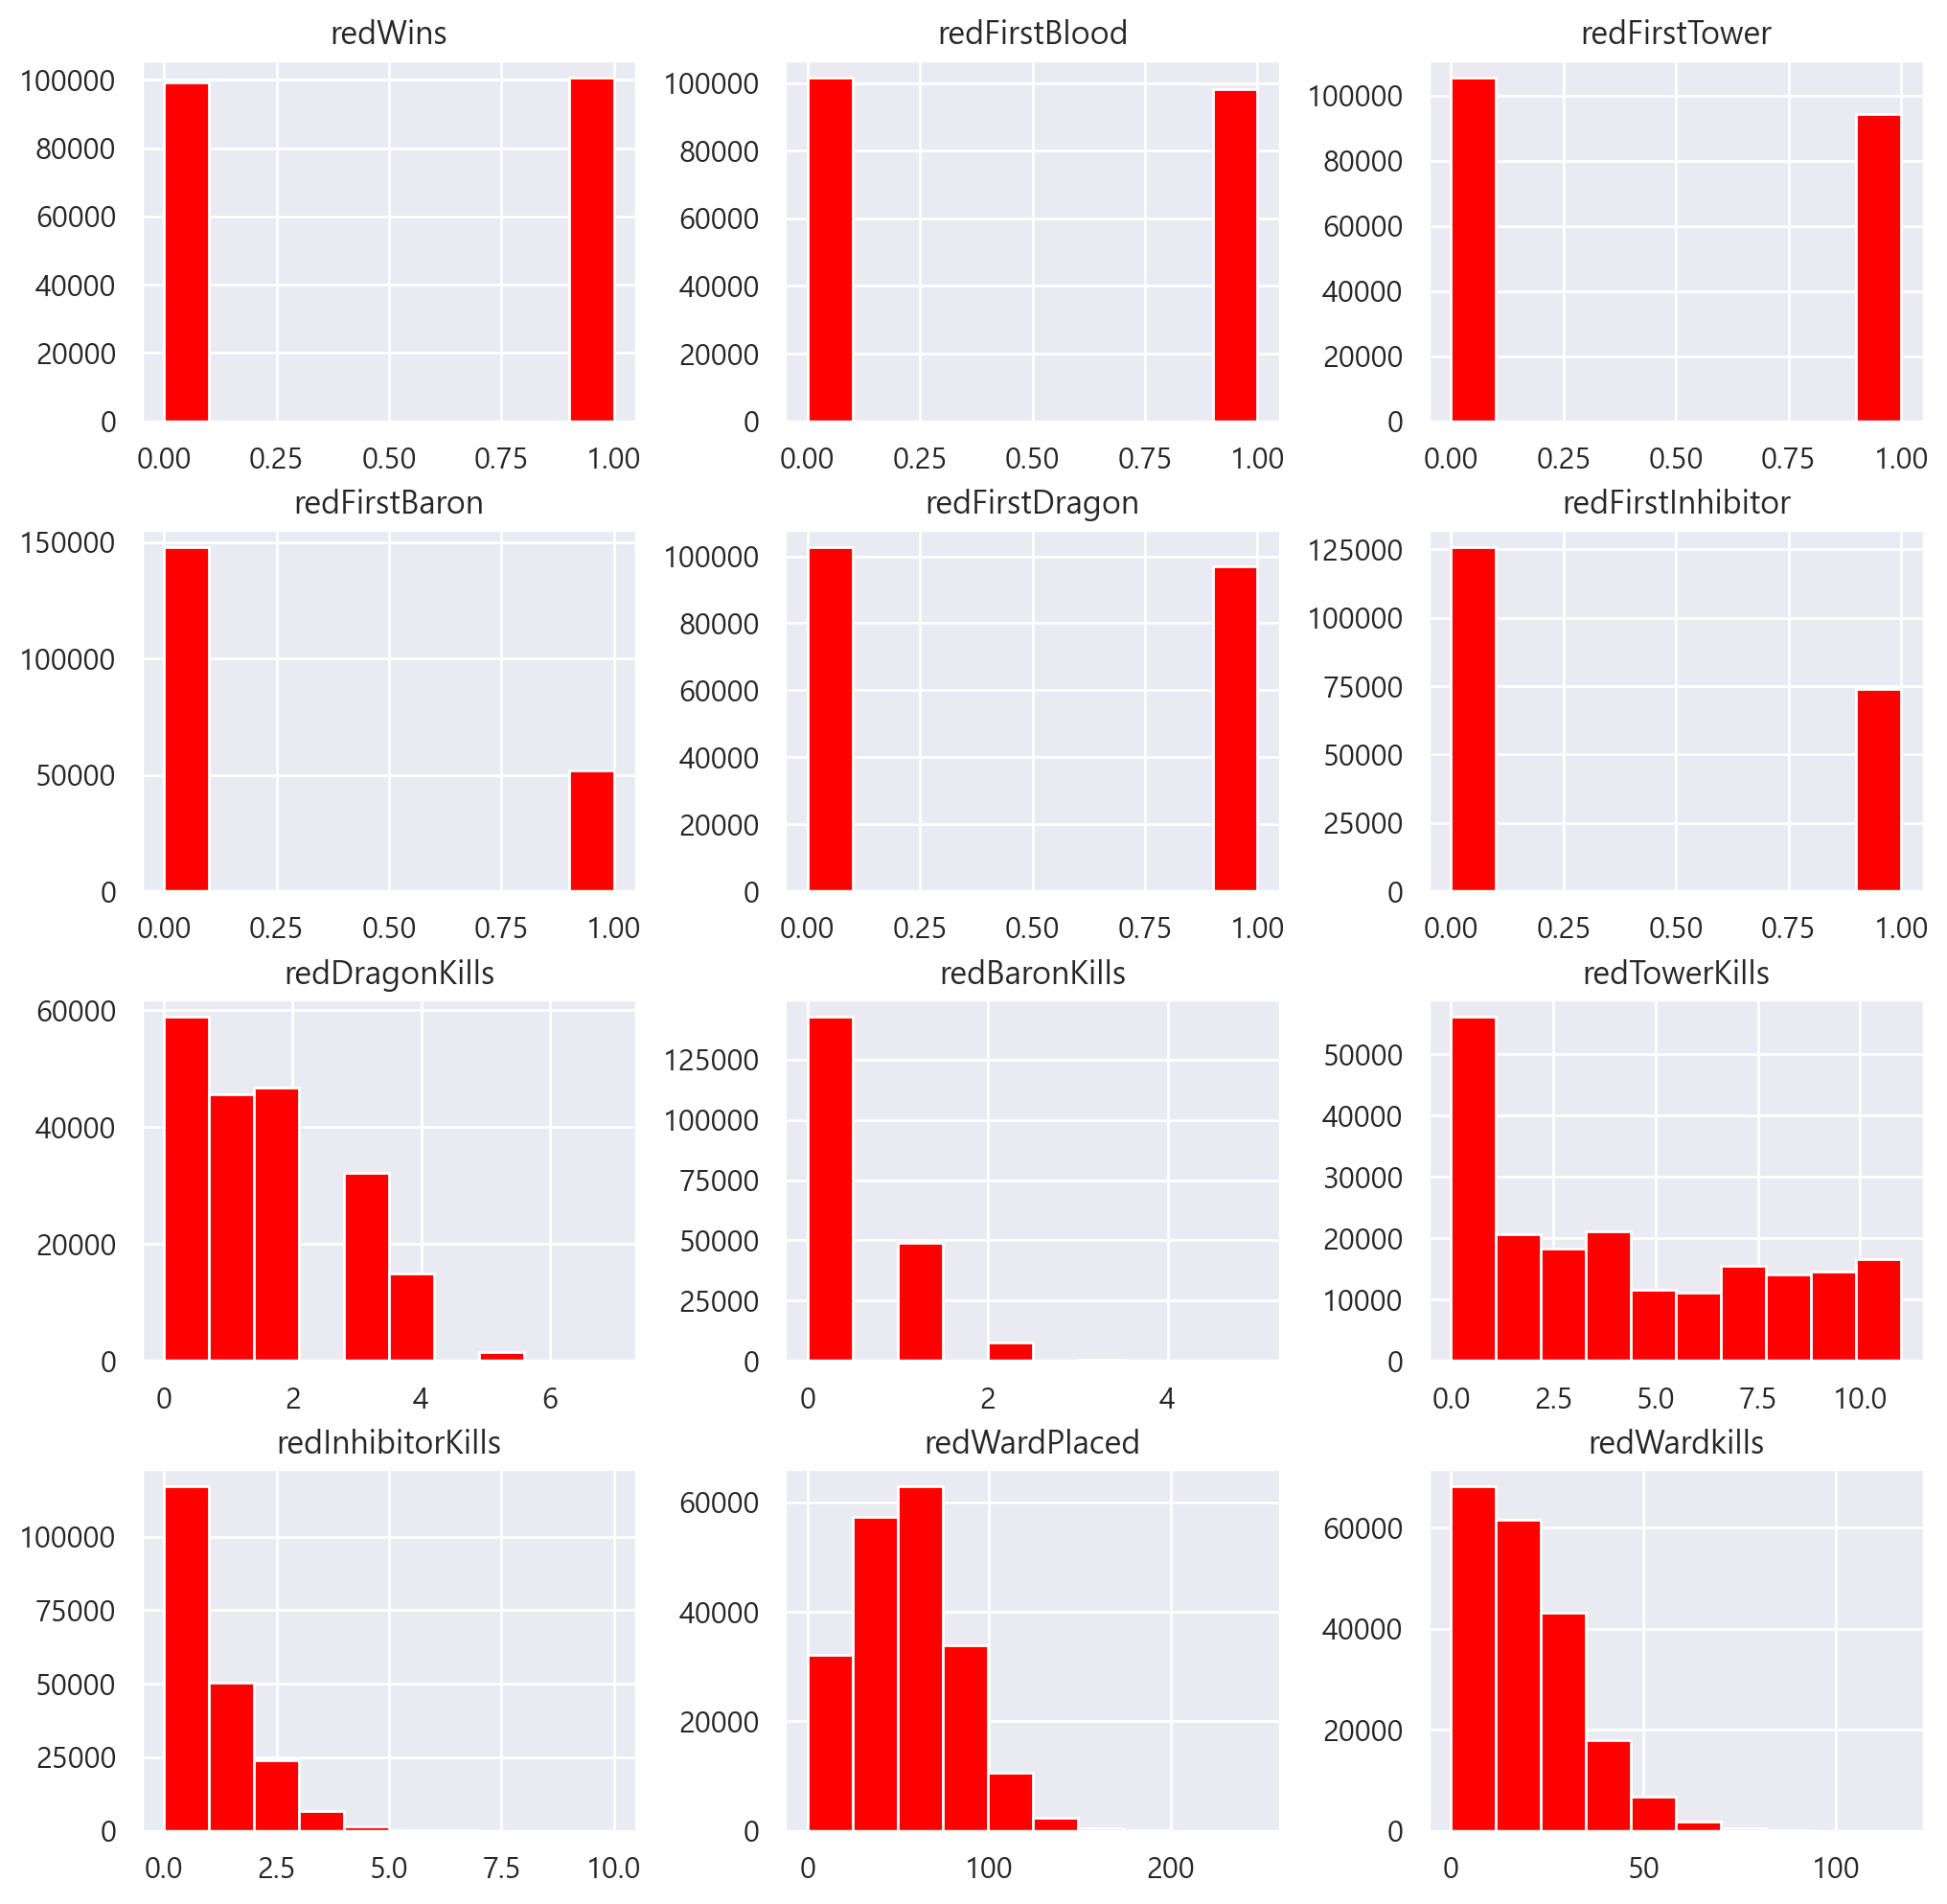

In [16]:
# 이상치 확인(레드팀)
# 히스토그램(Histogram)으로 이상치 확인
# 컬럼이 너무 많아 그래프가 제대로 표현되지 않으므로 나눠서 그림
red_df.iloc[:, :12].hist(figsize=(12, 12), color='red')

array([[<Axes: title={'center': 'redDeath'}>,
        <Axes: title={'center': 'redAssist'}>,
        <Axes: title={'center': 'redChampionDamageDealt'}>,
        <Axes: title={'center': 'redTotalGold'}>],
       [<Axes: title={'center': 'redTotalMinionKills'}>,
        <Axes: title={'center': 'redTotalLevel'}>,
        <Axes: title={'center': 'redAvgLevel'}>,
        <Axes: title={'center': 'redJungleMinionKills'}>],
       [<Axes: title={'center': 'redKillingSpree'}>,
        <Axes: title={'center': 'redTotalHeal'}>,
        <Axes: title={'center': 'redObjectDamageDealt'}>,
        <Axes: title={'center': 'gameMin'}>],
       [<Axes: title={'center': 'gameSec'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

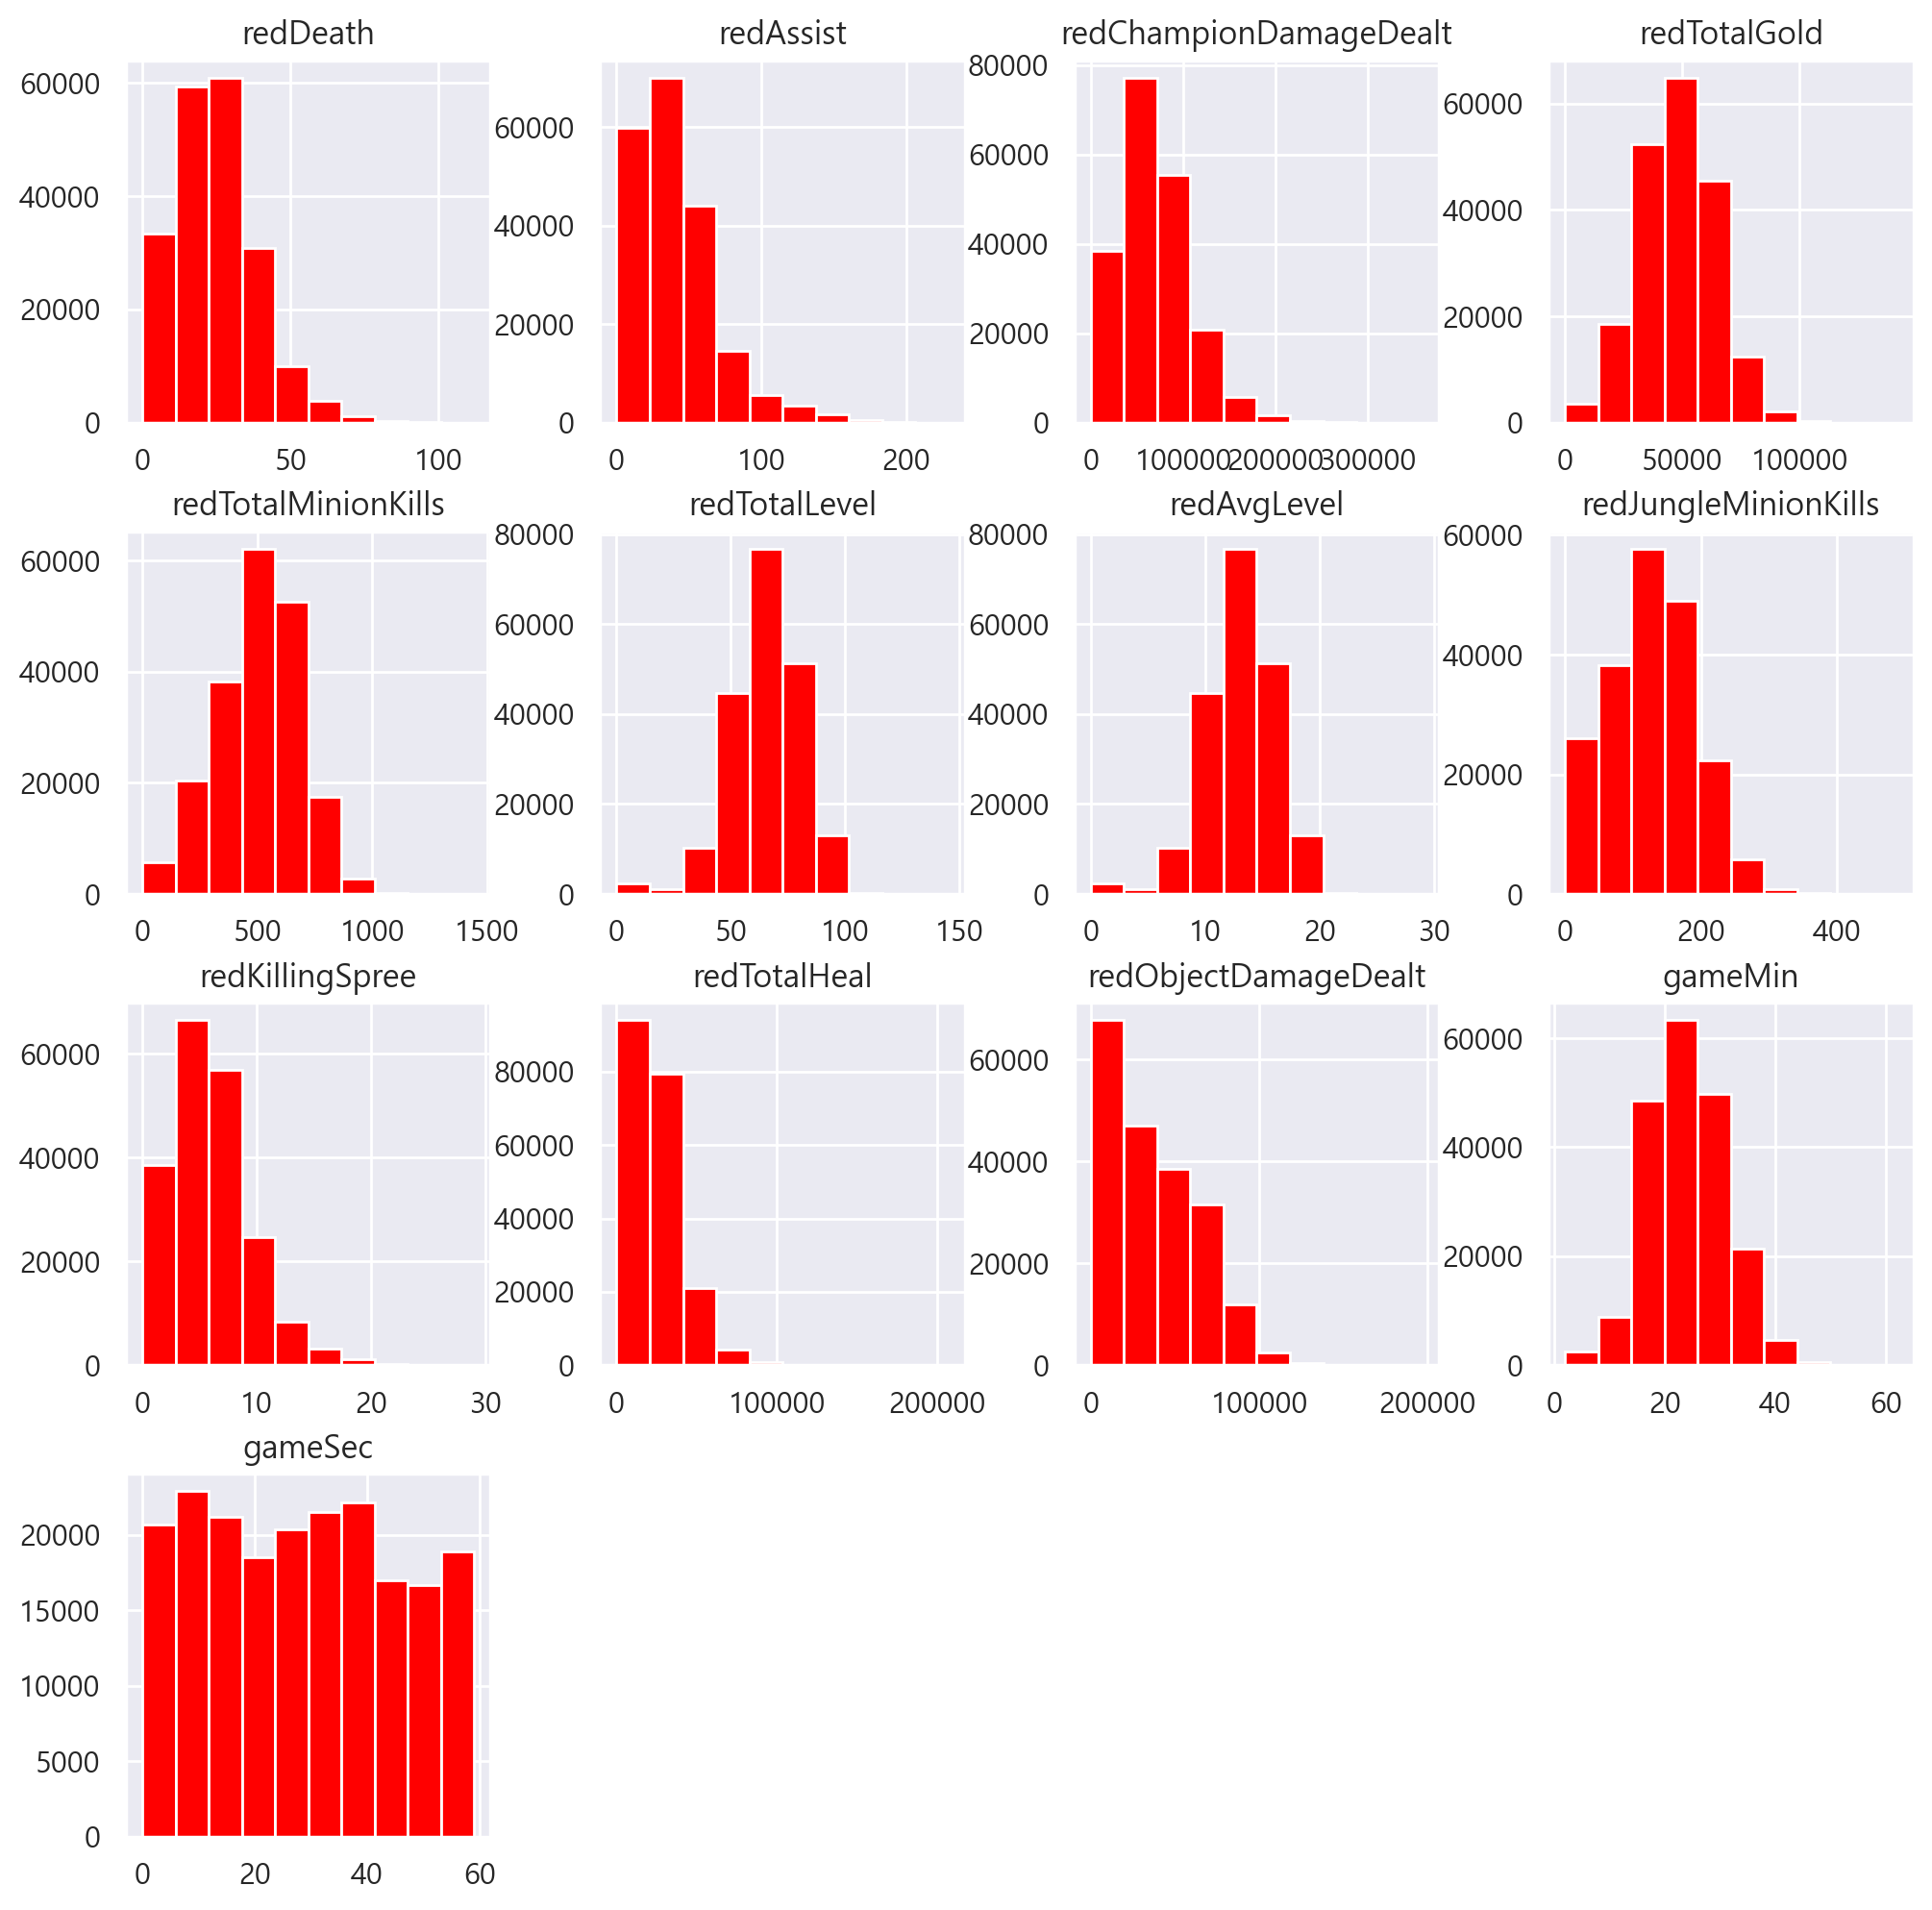

In [17]:
red_df.iloc[:, 13:].hist(figsize=(12, 12), color='red')

# 탐색적 데이터 분석

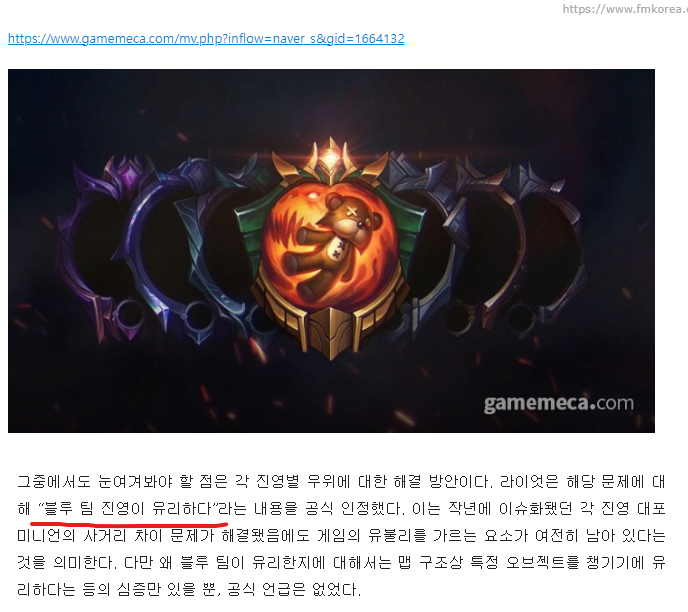

In [18]:
# 블루팀과 레드팀 어느팀이 승률이 더 높은가?
# 위 가설을 검증하기 위해 우선 블루팀과 레드팀의 총 승률을 계산한다.

# 블루팀의 전체 경기
blue_all = blue_df["blueWins"]
blue_win = blue_df["blueWins"] == 1

# 블루팀 승률
blue_winning = blue_win.sum() / blue_win.count() * 100
blue_winning = float("{:.2f}".format(blue_winning))
blue_winning

49.6

In [19]:
# 레드팀의 전체 경기
red_all = red_df["redWins"]
red_win = red_df["redWins"] == 1

# 레드팀 승률
red_winning = red_win.sum() / red_win.count() * 100
red_winning = float("{:.2f}".format(red_winning))
red_winning

50.4

* 블루팀 승률 49.6, 레드팀 승률 50.4로 레드팀이 승률이 더 높음을 확인 할 수 있다.
* 그렇다면 왜 레드 팀 승률이 더 높을까에 대해 알아보겠다.
* 알아보기 전에 "리그오브레전드"라는 게임에서 승리하려면
* 다양한 요인들이 존재하는데 그 중에 가장 먼저 세운 가설인
* "게임을 승리하려면 상대보다 타워를 더 많이 밀어야한다." 에 대해 검증해보겠다.

C:\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


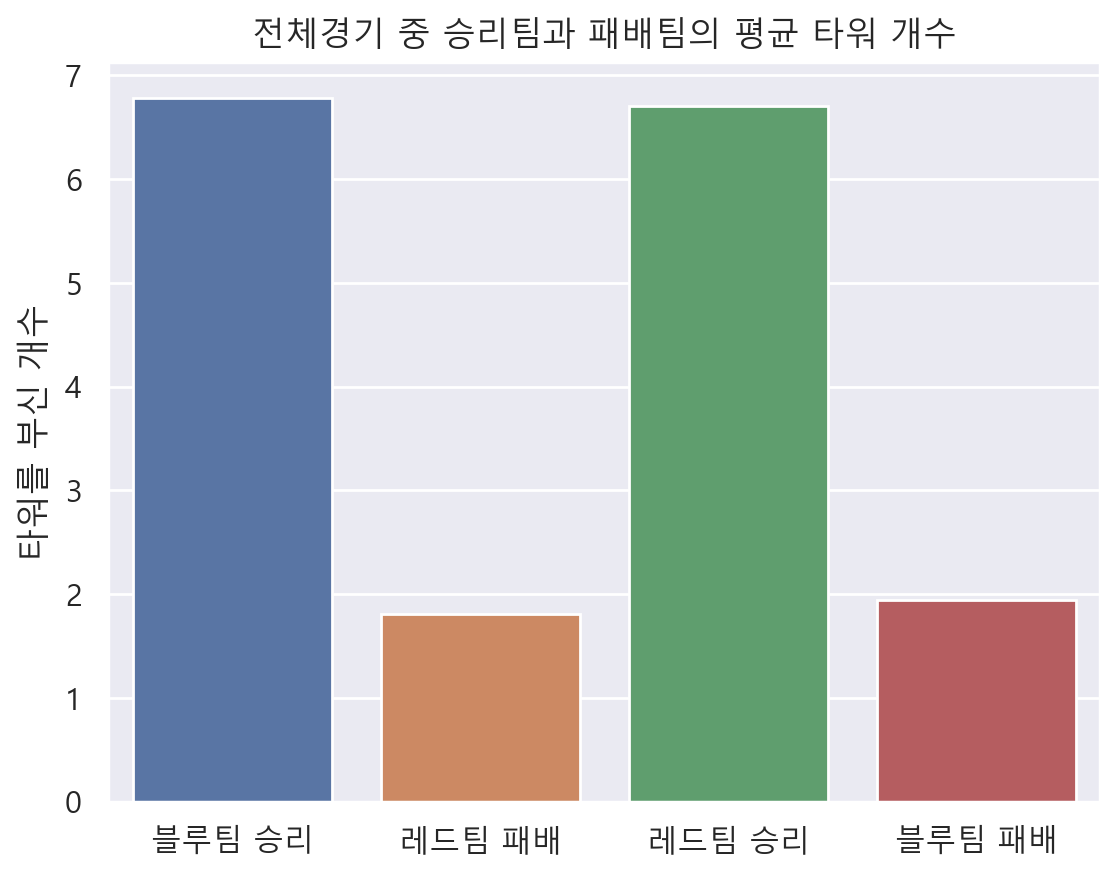

In [20]:
# 블루팀 승리 여부에 따라 데이터를 분리
blue_win_df = lol_df[lol_df['blueWins'] == 1]
blue_lost_df = lol_df[lol_df['blueWins'] == 0]
red_win_df = lol_df[lol_df['blueWins'] == 0]
red_lost_df = lol_df[lol_df['blueWins'] == 1]

# 블루팀과 레드팀의 평균 타워 파괴 수 계산(이겼을때 졌을때)
blue_win_mean_tower_kills = blue_win_df['blueTowerKills'].mean()
blue_lost_mean_tower_kills = blue_lost_df['blueTowerKills'].mean()
red_win_mean_tower_kills = red_win_df['redTowerKills'].mean()
red_lost_mean_tower_kills = red_lost_df['redTowerKills'].mean()

# 시각화
sns.barplot(x=['블루팀 승리','레드팀 패배', '레드팀 승리', '블루팀 패배'], y=[blue_win_mean_tower_kills, red_lost_mean_tower_kills, red_win_mean_tower_kills, blue_lost_mean_tower_kills])
plt.title('전체경기 중 승리팀과 패배팀의 평균 타워 개수')
plt.ylabel('타워를 부신 개수')
plt.show()

#### 위 그래프를 통해 우리는 블루팀이던 레드팀이던 패배했을때보다 승리했을때 평균적으로 타워를 더 많이 부셨음을 볼 수 있다.
#### 이어서 두번째 가설인 "게임을 승리하려면 상대보다 킬수가 더 많아야한다."를 검증해보겠다.

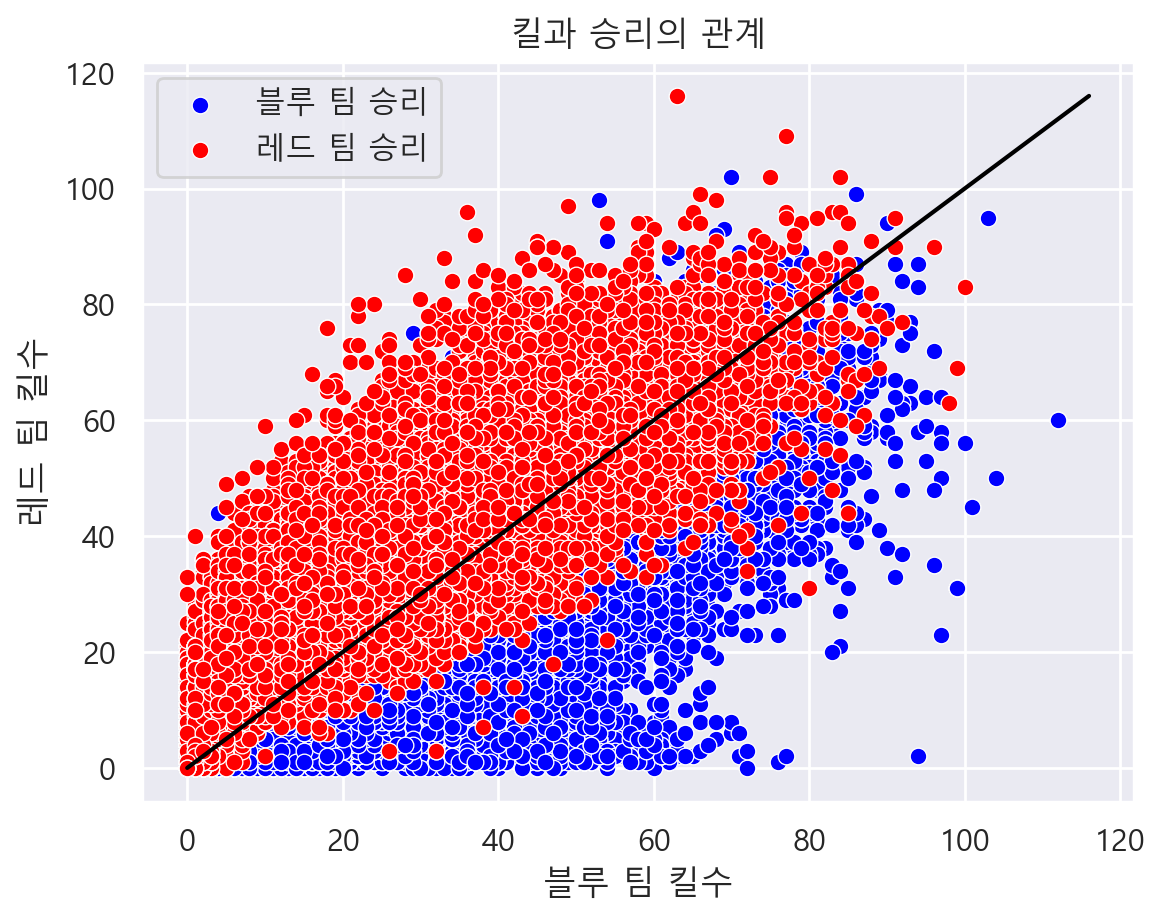

In [21]:
# 점 그래프로 킬 수와 승리 여부의 관계 시각화
sns.scatterplot(data=blue_win_df, x='blueKills', y='redKills', color='blue', label='블루 팀 승리')
sns.scatterplot(data=red_win_df, x='blueKills', y='redKills', color='red', label='레드 팀 승리')

# 45도 직선 추가
x = list(range(max(lol_df['blueKills'].max(), lol_df['redKills'].max()) + 1))
plt.plot(x, x, color='black', linestyle='-')

# 그래프 제목 설정
plt.title('킬과 승리의 관계')

# x축 레이블 설정
plt.xlabel('블루 팀 킬수')

# y축 레이블 설정
plt.ylabel('레드 팀 킬수')

# 범례 위치 조정
plt.legend(loc='upper left')

# 그래프 보이기
plt.show()

#### 위 그래프를 통해 45도 직선 밑으로는 블루팀 킬 수 가 더 많기 때문에 우리가 세운 가설에 인해 블루팀이 승리하는 것이 맞는데,
#### 레드팀이 킬을 더 적게하고도 승리한 게임 수가 많은 것을 볼 수 있다. 
#### 따라서 킬 수는 승리와의 관계에서 그렇게 큰 영향을 미치지 않는 것 같다.
#### 그렇다면 네번째 가설인 "블루팀과 레드팀 어느 팀이 어떤 오브젝트(드래곤, 바론)를 챙기기에 유리한가 
#### - 지형이 오브젝트에 미치는 영향"을 살펴보도록 하자

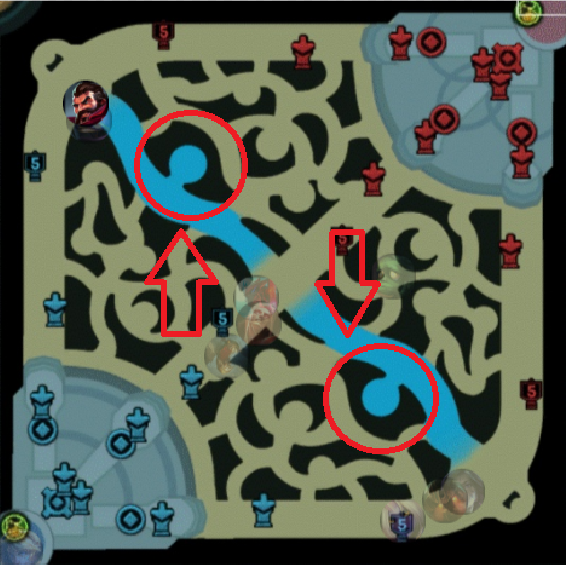

사람들은 흔히 레드팀이 블루팀보다 드래곤 싸움에 유리하고, 블루팀이 레드팀보다 바론 싸움에 유리하다고 한다.<br>
그 이유를 위치적인 이점 때문이라고 하는데 위 미니맵에서 볼 수 있지만, 바론과 드래곤 둥지에는 큰 벽이 둘러싸여져 있다.<br>
블루팀은 드래곤을 먹기 위해선 큰 벽을 돌아가거나, 스킬이나 소환사 주문 스킬인 점멸을 사용해서 넘어야 하지만<br>
레드팀은 장애물에 제약 없이 바로 오브젝트 싸움을 시작하면 된다. 바론도 동일한 이유이다. 

In [58]:
# 블루팀이 평균적으로 드래곤을 챙긴 횟수와 레드팀이 평균적으로 드래곤을 챙긴 횟수 비교

print(f'블루팀은 드래곤을 평균적으로 {blue_df["blueDragonKills"].mean()}회 챙겼고, 레드팀은 바론을 평균적으로 {red_df["redDragonKills"].mean()}회 챙겼음.')

블루팀은 드래곤을 평균적으로 1.356743778917094회 챙겼고, 레드팀은 바론을 평균적으로 1.5188745779667374회 챙겼음.


In [59]:
# 블루팀이 평균적으로 바론을 챙긴 횟수와 레드팀이 평균적으로 바론을 챙긴 횟수 비교

print(f'블루팀은 바론을 평균적으로 {blue_df["blueBaronKills"].mean()}회 챙겼고, 레드팀은 바론을 평균적으로 {red_df["redBaronKills"].mean()}회 챙겼음.')

블루팀은 바론을 평균적으로 0.29773665124421655회 챙겼고, 레드팀은 바론을 평균적으로 0.32964861823183694회 챙겼음.


<hr>

#### 평균적으로 드래곤과 바론을 챙긴 횟수를 보면 지형에 관계없이 레드팀이 드래곤과 바론 모두 블루팀보다 더 잘 챙긴 것을 볼 수 있다.
#### 개인적인 생각으로는 지형적인 이유보다는 실제 인게임에서는 게임에서 더 유리한 팀이 드래곤과 바론을
#### 먼저 챙길 기회가 있기 때문이라고 생각한다.

#### 다음은 "게임을 승리하려면 상대보다 골드량이 더 많아야한다."를 검증해보겠다.

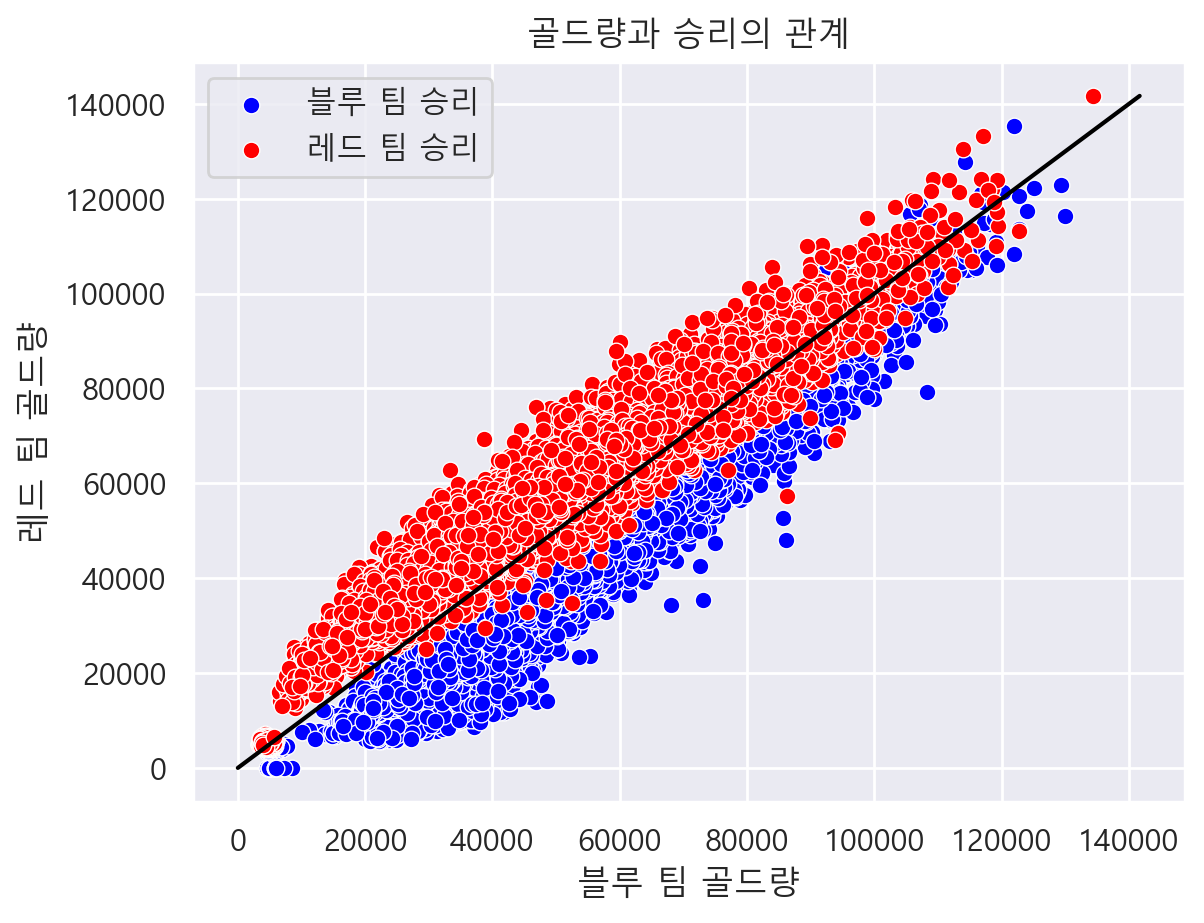

In [62]:
# 점 그래프로 골드량과 승리 여부의 관계 시각화
sns.scatterplot(data=blue_win_df, x='blueTotalGold', y='redTotalGold', color='blue', label='블루 팀 승리')
sns.scatterplot(data=red_win_df, x='blueTotalGold', y='redTotalGold', color='red', label='레드 팀 승리')

# 45도 직선 추가
x = list(range(max(lol_df['blueTotalGold'].max(), lol_df['redTotalGold'].max()) + 1))
plt.plot(x, x, color='black', linestyle='-')

# 그래프 제목 설정
plt.title('골드량과 승리의 관계')

# x축 레이블 설정
plt.xlabel('블루 팀 골드량')

# y축 레이블 설정
plt.ylabel('레드 팀 골드량')

# 범례 위치 조정
plt.legend(loc='upper left')

# 그래프 보이기
plt.show()

#### 골드량과 승리의 관계를 봤을 때 무조건 골드가 상대보다 더 많다고 해서 승리를 하는 것은 아니지만,
#### 킬 수와 승리의 관계 그래프와 비교해봤을 때보단 확실히 골드량이 킬 수보다 승리와 밀접한 관계를 형성한다.
#### 마지막으로 게임에서 승리와 밀접한 연관이 있는 요소들을 상관관계를 통해 알아보겠다.

In [84]:
# 블루팀의 상관계수
blue_df_corr = blue_df[blue_df.columns].corr()
blue_df_corr

blueWins  blueFirstBlood  blueFirstTower  \
blueWins                 1.000000        0.206563        0.465065   
blueFirstBlood           0.206563        1.000000        0.216389   
blueFirstTower           0.465065        0.216389        1.000000   
blueFirstBaron           0.366600        0.053508        0.141800   
blueFirstDragon          0.271273        0.140890        0.214170   
blueFirstInhibitor       0.658354        0.154985        0.383554   
blueDragonKills          0.454920        0.135877        0.293822   
blueBaronKills           0.353205        0.045859        0.120063   
blueTowerKills           0.717463        0.189529        0.487180   
blueInhibitorKills       0.574076        0.124675        0.313102   
blueWardPlaced           0.026268        0.011033        0.064126   
blueWardkills            0.063604        0.016463        0.089900   
blueKills                0.418770        0.134244        0.264502   
blueDeath               -0.420192       -0.133978       -0.226034   
blueAssist               0.333881        0.085046        0.167282   
blueChampionDamageDealt  0.158049        0.040506        0.116505   
blueTotalGold            0.253280        0.077314        0.199096   
blueTotalMinionKills     0.068853        0.037020        0.116529   
blueTotalLevel           0.197920        0.050645        0.154996   
blueAvgLevel             0.197920        0.050645        0.154996   
blueJungleMinionKills    0.199203        0.055741        0.189912   
blueKillingSpree         0.391922        0.122588        0.256141   
blueTotalHeal            0.197769        0.032841        0.103744   
blueObjectDamageDealt    0.522638        0.143244        0.380466   
gameMin                 -0.017392        0.000743        0.047614   
gameSec                 -0.000531       -0.001592        0.013213   

                         blueFirstBaron  blueFirstDragon  blueFirstInhibitor  \
blueWins                       0.366600         0.271273            0.658354   
blueFirstBlood                 0.053508         0.140890            0.154985   
blueFirstTower                 0.141800         0.214170            0.383554   
blueFirstBaron                 1.000000         0.129840            0.408707   
blueFirstDragon                0.129840         1.000000            0.176714   
blueFirstInhibitor             0.408707         0.176714            1.000000   
blueDragonKills                0.434385         0.586840            0.402066   
blueBaronKills                 0.884838         0.121506            0.386185   
blueTowerKills                 0.528745         0.291841            0.778773   
blueInhibitorKills             0.407202         0.130026            0.786436   
blueWardPlaced                 0.409699         0.175698            0.119182   
blueWardkills                  0.401971         0.135115            0.146919   
blueKills                      0.292274         0.066870            0.458768   
blueDeath                     -0.032453        -0.214649           -0.161804   
blueAssist                     0.221837        -0.051311            0.397389   
blueChampionDamageDealt        0.305405        -0.003708            0.309649   
blueTotalGold                  0.419687         0.073745            0.388722   
blueTotalMinionKills           0.400900         0.190571            0.158538   
blueTotalLevel                 0.381655         0.036522            0.334805   
blueAvgLevel                   0.381655         0.036522            0.334805   
blueJungleMinionKills          0.481974         0.267940            0.258629   
blueKillingSpree               0.259830         0.049871            0.423076   
blueTotalHeal                  0.378193         0.085514            0.295106   
blueObjectDamageDealt          0.647758         0.351228            0.552440   
gameMin                        0.402425         0.090539            0.166257   
gameSec                        0.013975         0.008565            0.012741   



In [85]:
# 블루팀 승리에 대한 상관계수가 낮은 순서대로 출력
blue_df_corr["blueWins"].sort_values()

blueDeath                 -0.420192
gameMin                   -0.017392
gameSec                   -0.000531
blueWardPlaced             0.026268
blueWardkills              0.063604
blueTotalMinionKills       0.068853
blueChampionDamageDealt    0.158049
blueTotalHeal              0.197769
blueTotalLevel             0.197920
blueAvgLevel               0.197920
blueJungleMinionKills      0.199203
blueFirstBlood             0.206563
blueTotalGold              0.253280
blueFirstDragon            0.271273
blueAssist                 0.333881
blueBaronKills             0.353205
blueFirstBaron             0.366600
blueKillingSpree           0.391922
blueKills                  0.418770
blueDragonKills            0.454920
blueFirstTower             0.465065
blueObjectDamageDealt      0.522638
blueInhibitorKills         0.574076
blueFirstInhibitor         0.658354
blueTowerKills             0.717463
blueWins                   1.000000
Name: blueWins, dtype: float64

<Axes: >

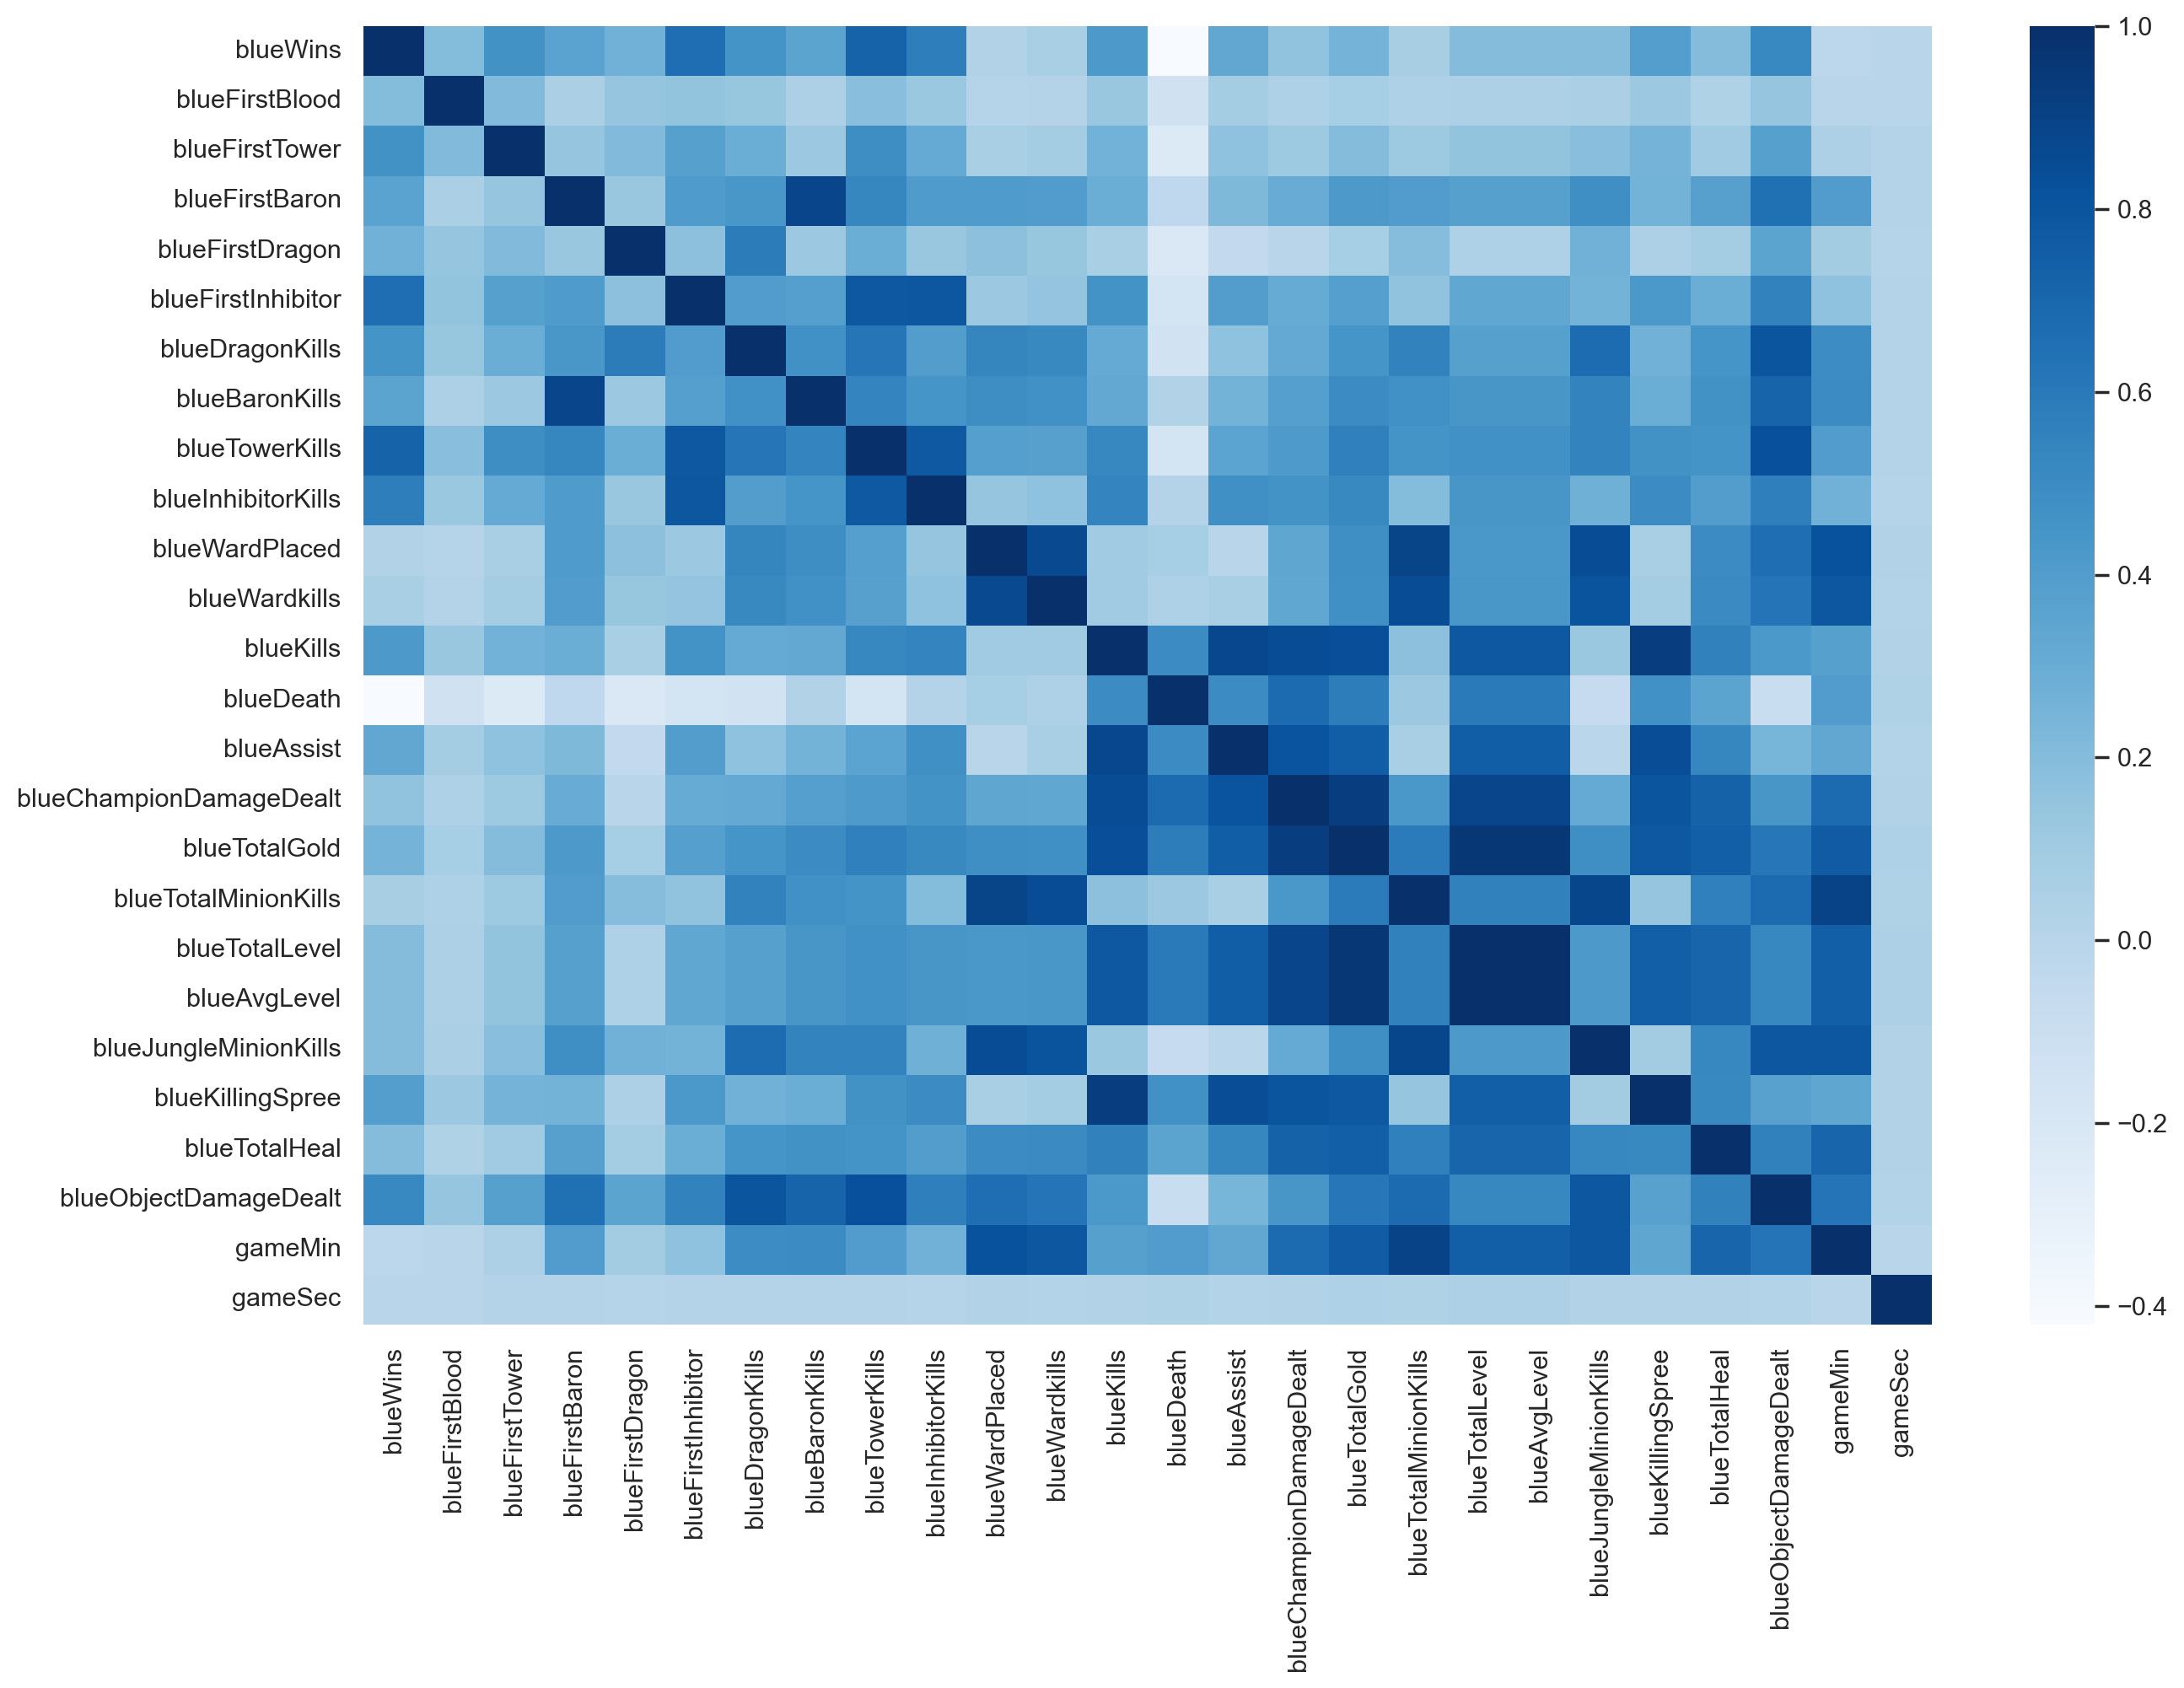

In [92]:
plt.figure(figsize=(15, 10))
sns.heatmap(data=blue_df_corr, fmt=".2f",cmap="Blues")

In [94]:
# 승리와 가장 밀접한 연관이 있는 7개를 가져왔다.

blue_df_corr["blueWins"].sort_values(ascending=False).head(7)

blueWins                 1.000000
blueTowerKills           0.717463
blueFirstInhibitor       0.658354
blueInhibitorKills       0.574076
blueObjectDamageDealt    0.522638
blueFirstTower           0.465065
blueDragonKills          0.454920
Name: blueWins, dtype: float64

In [95]:
# 래드팀의 상관계수
red_df_corr = red_df[red_df.columns].corr()
red_df_corr

redWins  redFirstBlood  redFirstTower  redFirstBaron  \
redWins                 1.000000       0.206992       0.464632       0.393278   
redFirstBlood           0.206992       1.000000       0.216971       0.057158   
redFirstTower           0.464632       0.216971       1.000000       0.135415   
redFirstBaron           0.393278       0.057158       0.135415       1.000000   
redFirstDragon          0.275924       0.140604       0.207959       0.162729   
redFirstInhibitor       0.645034       0.152508       0.376333       0.423613   
redDragonKills          0.465617       0.136974       0.267785       0.470929   
redBaronKills           0.379211       0.049299       0.110662       0.878863   
redTowerKills           0.722430       0.187918       0.465802       0.553182   
redInhibitorKills       0.569259       0.124086       0.312991       0.416621   
redWardPlaced           0.060136       0.019924       0.021577       0.426605   
redWardkills            0.098500       0.028411       0.046406       0.426619   
redKills                0.422315       0.142620       0.269381       0.307563   
redDeath               -0.416843      -0.125591      -0.221374      -0.049991   
redAssist               0.334433       0.095136       0.172010       0.230481   
redChampionDamageDealt  0.172681       0.052334       0.113616       0.313540   
redTotalGold            0.274216       0.090362       0.188846       0.433180   
redTotalMinionKills     0.101708       0.043859       0.081120       0.422971   
redTotalLevel           0.219959       0.067036       0.148686       0.395558   
redAvgLevel             0.219959       0.067036       0.148686       0.395558   
redJungleMinionKills    0.239547       0.062068       0.158974       0.505036   
redKillingSpree         0.399225       0.134770       0.264582       0.271292   
redTotalHeal            0.221568       0.044171       0.090391       0.393073   
redObjectDamageDealt    0.551108       0.147441       0.351244       0.671103   
gameMin                 0.017392       0.011613       0.019893       0.421932   
gameSec                 0.000531       0.005275       0.005201       0.015378   

                        redFirstDragon  redFirstInhibitor  redDragonKills  \
redWins                       0.275924           0.645034        0.465617   
redFirstBlood                 0.140604           0.152508        0.136974   
redFirstTower                 0.207959           0.376333        0.267785   
redFirstBaron                 0.162729           0.423613        0.470929   
redFirstDragon                1.000000           0.172032        0.604635   
redFirstInhibitor             0.172032           1.000000        0.391071   
redDragonKills                0.604635           0.391071        1.000000   
redBaronKills                 0.150741           0.398301        0.506658   
redTowerKills                 0.303622           0.774598        0.628048   
redInhibitorKills             0.120846           0.785342        0.386791   
redWardPlaced                 0.238005           0.122822        0.576219   
redWardkills                  0.204627           0.154448        0.557059   
redKills                      0.055486           0.458317        0.319861   
redDeath                     -0.237772          -0.147781       -0.157938   
redAssist                    -0.065917           0.397826        0.164619   
redChampionDamageDealt       -0.001946           0.316905        0.323923   
redTotalGold                  0.086965           0.396182        0.462736   
redTotalMinionKills           0.254200           0.165862        0.594707   
redTotalLevel                 0.052286           0.345548        0.396649   
redAvgLevel                   0.052286           0.345548        0.396649   
redJungleMinionKills          0.332233           0.266455        0.708044   
redKillingSpree               0.039521           0.427005        0.274846   
redTotalHeal                  0.104363           0.303202        0

In [97]:
# 레드팀 승리에 대한 상관계수가 낮은 순서대로 출력
red_df_corr["redWins"].sort_values()

redDeath                 -0.416843
gameSec                   0.000531
gameMin                   0.017392
redWardPlaced             0.060136
redWardkills              0.098500
redTotalMinionKills       0.101708
redChampionDamageDealt    0.172681
redFirstBlood             0.206992
redAvgLevel               0.219959
redTotalLevel             0.219959
redTotalHeal              0.221568
redJungleMinionKills      0.239547
redTotalGold              0.274216
redFirstDragon            0.275924
redAssist                 0.334433
redBaronKills             0.379211
redFirstBaron             0.393278
redKillingSpree           0.399225
redKills                  0.422315
redFirstTower             0.464632
redDragonKills            0.465617
redObjectDamageDealt      0.551108
redInhibitorKills         0.569259
redFirstInhibitor         0.645034
redTowerKills             0.722430
redWins                   1.000000
Name: redWins, dtype: float64

<Axes: >

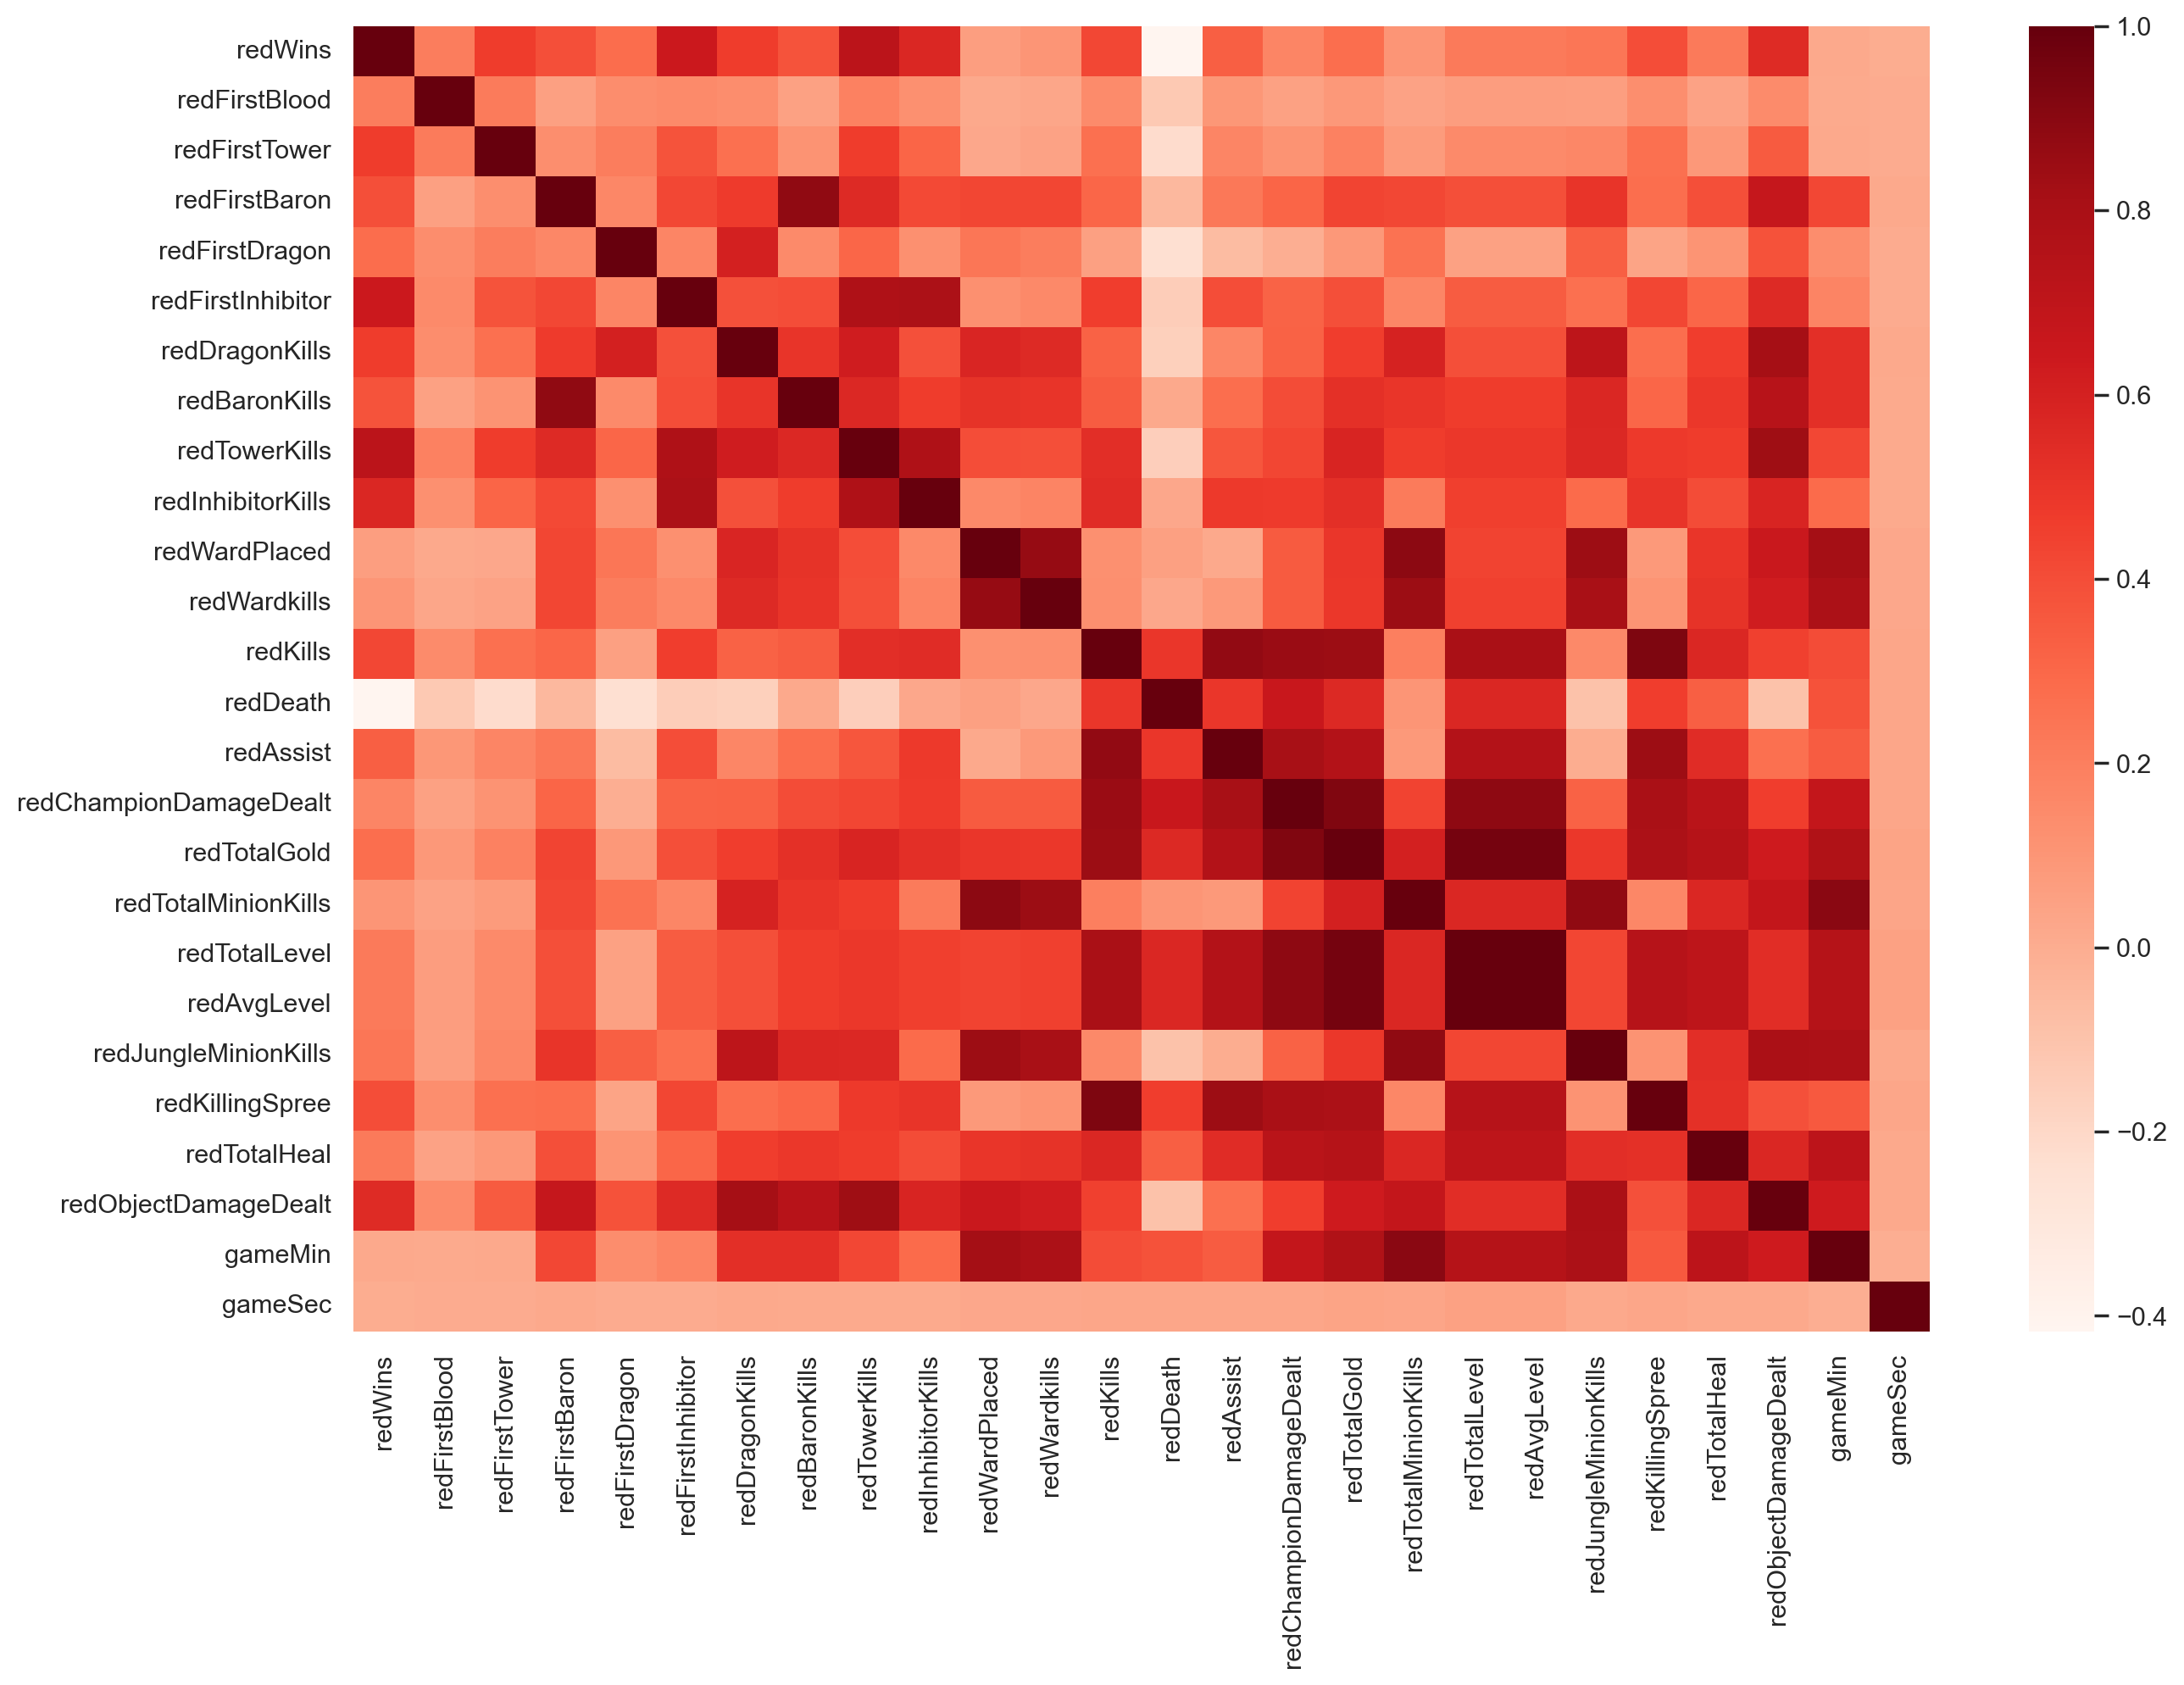

In [91]:
plt.figure(figsize=(15, 10))
sns.heatmap(data=red_df_corr, fmt=".2f",cmap="Reds")

In [98]:
# 승리와 가장 밀접한 연관이 있는 7개를 가져왔다.

red_df_corr["redWins"].sort_values(ascending=False).head(7)

redWins                 1.000000
redTowerKills           0.722430
redFirstInhibitor       0.645034
redInhibitorKills       0.569259
redObjectDamageDealt    0.551108
redDragonKills          0.465617
redFirstTower           0.464632
Name: redWins, dtype: float64

# 결론

#### 양팀의 상관계수를 비교해본 결과 두팀 모두 타워 킬, 첫번째 억제기, 억제기 킬, 오브젝트 데미지 까진 동일한 결과가 나왔지만,
#### 승률이 더 높은 레드팀에선 드레곤킬이 첫번째 타워보다 중요한 영향을 미치는 것으로 확인된다.
#### 따라서 승리에 가장 밀접한 연관이 있는건 <b>타워를 몇개 부셨냐가</b> 가장 중요하고, 
#### 첫번째의 킬, 오브젝트, 억제기중 <b>억제기를 상대팀보다 먼저 부시는 것</b>이 게임 승리에 가장 큰 영향을 미치는 것으로 알 수 있다.

# 아쉬웠던 점

* 데이터가 분대로 나눠져있지 않아서 경기 결과만 보고 분석한 점이 아쉽게 느껴졌다.
* 리그오브레전드 드레곤 오브젝트는 "화염", "바람", "대지", "마법공학" 이렇게 네개의 드레곤으로 나눠지고 각 드레곤마다 다른 효과가 있으며,<br>
  승리에 더 높은 기여도를 주는 드레곤이 있는데 데이터에서는 드레곤의 종류가 나눠져있지 않고 통일되어 있어서 아쉬웠다.
* 전령과 유충이라는 새로운 오브젝트가 나왔지만 데이터에는 적용이 되어있지 않아서 정확한 분석을 하지 못하였다.